# Risk Measures and Portfolio Optimization: Expanded

**Prepared by:** Andrew Marquardt and Yohannes Mariam (amarquar@nd.edu,ymariam@nd.edu, 2024) \\
Credit to Madelyn Watson for the basis of the problem and majority of source material \\

Primary source: https://ndcbe.github.io/optimization/notebooks/4/RiskMeasures.html
(we also retained the sources Madelyn listed for the problem formulation)

NOTE: We included the original code from the original notebook and executed it as a comparison point for our presentation; it is briefly mentioned in the results synopsis, but since we used the charts generated by these functions in the presentation and they were already written, it made no sense to dump them from this notebook, so we put them in the front.

In [3]:
# Imports
import sys
if "google.colab" in sys.modules:
    !wget "https://raw.githubusercontent.com/ndcbe/optimization/main/notebooks/helper.py"
    import helper
    helper.easy_install()
    helper.install_idaes()
    helper.install_ipopt()
else:
    sys.path.insert(0, '../')
    import helper
    helper.install_idaes()
    helper.install_ipopt()
helper.set_plotting_style()

import pandas as pd
import numpy as np
import pyomo.environ as pyo
import matplotlib.pyplot as plt

--2024-10-08 02:20:40--  https://raw.githubusercontent.com/ndcbe/optimization/main/notebooks/helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6493 (6.3K) [text/plain]
Saving to: ‘helper.py’

helper.py           100%[===================>]   6.34K  --.-KB/s    in 0s      

2024-10-08 02:20:40 (64.8 MB/s) - ‘helper.py’ saved [6493/6493]

Installing idaes via pip...
idaes was successfully installed
idaes, version 2.6.0


Running idaes get-extensions to install Ipopt, k_aug, and more...
Checking solver versions:
Ipopt 3.13.2 (x86_64-pc-linux-gnu), ASL(20190605)



[K_AUG] 0.1.0, Part of the IDAES PSE framework
Please visit https://idaes.org/ (x86_64-pc-linux-gnu), ASL(20190605)



Couenne 0.5.8 -- an Open-Source solver for Mixed Integer Nonlinear Optimiz

### Visualize Input Data

In [5]:
#Load Data From CSV files stored on Github
path_cap='https://raw.githubusercontent.com/MadelynnWatson/RiskMeasures/main/Capacity.csv'
path_opex = 'https://raw.githubusercontent.com/MadelynnWatson/RiskMeasures/main/OPEX.csv'
path_conv = 'https://raw.githubusercontent.com/MadelynnWatson/RiskMeasures/main/conversions.csv'
path_gen = 'https://raw.githubusercontent.com/MadelynnWatson/RiskMeasures/main/generation.csv'
path_hp = 'https://raw.githubusercontent.com/MadelynnWatson/RiskMeasures/main/historicalprices.csv'
df_maxcap = pd.read_csv(path_cap)
df_prodcost = pd.read_csv(path_opex)
df_conv = pd.read_csv(path_conv)
df_gen = pd.read_csv(path_gen)
df_hp = pd.read_csv(path_hp)

In [6]:
## Uncomment to Display Additional Data in Tables
display(df_maxcap)
display(df_prodcost)
# display(df_conv)
# display(df_gen)

,process,capacity,units
0,mill,3000000,tonne sugarcane
1,fact,1541400,tonne juice
2,dist,2202000,tonne juice


,saleable_product,cost,units
0,sug,321.92,$/tonne
1,eth,502.01,$/m3
2,fre,1.98,$/MWh
3,reg,1.98,$/MWh


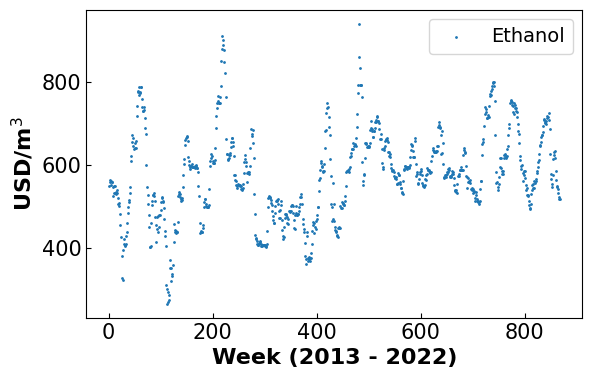

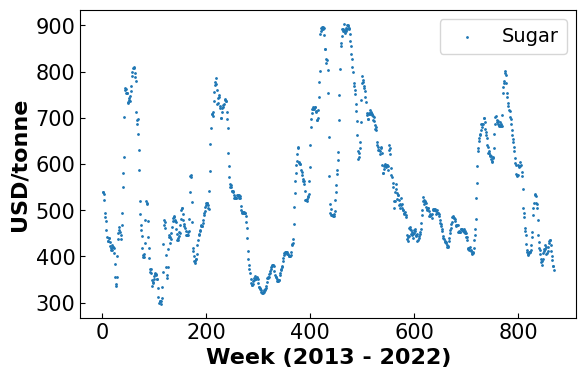

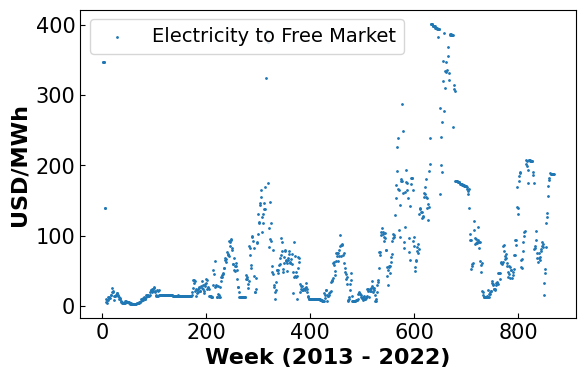

In [ ]:
#Plot historical prices
x = np.arange(1,len(df_hp['eth'])+ 1)
fig, ax = plt.subplots(figsize=(6.4, 4))
plt.scatter(x,df_hp['eth'],1, label = 'Ethanol')
plt.xlabel('Week (2013 - 2022)', fontsize = 16, fontweight='bold')
plt.ylabel('USD/m$^3$', fontsize = 16, fontweight = 'bold')
plt.legend(fontsize = 14)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.tick_params(direction="in")
plt.show()

fig, ax = plt.subplots(figsize=(6.4, 4))
plt.scatter(x,df_hp['sug'],1, label = 'Sugar')
plt.xlabel('Week (2013 - 2022)', fontsize = 16, fontweight='bold')
plt.ylabel('USD/tonne', fontsize = 16, fontweight = 'bold')
plt.legend(fontsize = 14)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.tick_params(direction="in")
plt.show()

fig, ax = plt.subplots(figsize=(6.4, 4))
plt.scatter(x,df_hp['fre'],1, label = 'Electricity to Free Market')
plt.xlabel('Week (2013 - 2022)', fontsize = 16, fontweight='bold')
plt.ylabel('USD/MWh', fontsize = 16, fontweight = 'bold')
plt.legend(fontsize = 14)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.tick_params(direction="in")
plt.show()

### Define Base Model in Pyomo

The following model is the base model first provided by the notebook authored by Madelyn Watson.  We've included it and run the code she wrote for each of the objectives in order to provide a reference point for the adjustments made in part 1 of our expansion of the results (the supply and demand adjustment).  Full credit to the original author for this code; our modifications are completed later on.

In [ ]:
#Create Base Model In Pyomo
def get_prodCost(i):
  og_price = df_prodcost['cost'][i]
  cost_uncertainty = np.random.uniform(0.85, 1.15)
  return og_price*cost_uncertainty
def create_model():
    '''
    This function buils a superstructure model in Pyomo for a sugarcane mill that can produce jet fuel.

    Inputs:
            product: desired product to maximize
            pathway: Excel sheet containing Jet fuel

    Returns: Pyomo model m
    '''
    m=pyo.ConcreteModel()

    #SETS
    resources = ['sug', 'eth', 'fre', 'reg', 'cane', 'jui', 'mol', 'bag', 'el-r']
    saleable_products = ['sug', 'eth', 'fre', 'reg']
    processes = ['mill', 'fact', 'dist','cogen']
    commodity = ['fre','sug','eth']

    #PARAMETERS
    #Scalars
    Ca = 3000000  # Annual Sugarcane Capacity
    beta = 0.9   # Confidence Level For CVaR Formulation
    price_reg = 72.5   # Price of electricity sold to the regulated market

    #Fill in Dictionaries with Excel Data
    max_cap = {}
    prodcost = {}
    conv = {}
    gen = {}
    hp = {}

    for i in range(len(df_maxcap['process'])):
        max_cap[df_maxcap['process'][i]] = df_maxcap['capacity'][i]

    for i in range(len(df_prodcost['saleable_product'])):
        prodcost[df_prodcost['saleable_product'][i]] = get_prodCost(i)
    for k in resources:
        for i in range(len(df_conv[k])):
            conv[(df_conv['resource'][i],df_conv['process'][i],k)] = df_conv[k][i]

    for k in resources:
        for i in range(len(df_gen[k])):
            gen[(df_gen['process'][i],k)] = df_gen[k][i]

    for k in commodity:
        for i in range(len(df_hp[k])):
            hp[(df_hp['q'][i],k)] = df_hp[k][i]

    N = len(df_hp['q'])
    q=[]
    for i in range(1,N+1):
        q.append('t%d' %(i))

    #PYOMO SETS
    m.resources = pyo.Set(initialize = resources)
    m.saleable_products = pyo.Set(initialize = saleable_products)
    m.processes = pyo.Set(initialize = processes)
    m.price_time_obs = pyo.Set(initialize = q)
    m.commodities = pyo.Set(initialize = commodity)

    m.N = pyo.Param(initialize = N)

    #VARIABLES
    #Positive Variables
    m.x = pyo.Var(m.resources, within = pyo.NonNegativeReals)
    m.r = pyo.Var(m.resources,m.processes, within = pyo.NonNegativeReals) #For juice split point
    m.profit = pyo.Var(m.price_time_obs)
    m.EP = pyo.Var()


    # Adding randomness in yield ranging from -20% to +20%
    yield_factors = np.random.uniform(0.8, 1.2, 6)
    jui_yield, bag_yield, sug_yield, mol_yield, el_yield, eth_yield = yield_factors

    #CONSTRAINTS
    #Superstructure Constraints
    def mill1(m):
        return m.x['jui']*jui_yield == Ca * conv['cane','mill','jui']
    m.milleq1 = pyo.Constraint(rule = mill1)

    def mill2(m):
        return m.x['bag']*bag_yield == Ca * conv['cane','mill','bag']
    m.milleq2 = pyo.Constraint(rule = mill2)

    def juice1(m):
        return m.x['jui']*jui_yield == m.r['jui','fact'] + m.r['jui','dist']
    m.juiceeq1 = pyo.Constraint(rule = juice1)

    def juice2(m):
        return m.r['jui','fact'] <= max_cap['fact']
    m.juiceeq2 = pyo.Constraint(rule = juice2)

    def juice3(m):
        return m.r['jui','dist'] <= max_cap['dist']
    m.juiceeq3 = pyo.Constraint(rule = juice3)

    def sugar1(m):
        return m.x['sug']*sug_yield == conv['jui', 'fact', 'sug'] * m.r['jui','fact']
    m.su1 = pyo.Constraint(rule = sugar1)

    def sugar2(m):
        return m.x['mol']*mol_yield == gen['fact','mol'] * m.x['sug']
    m.su2 = pyo.Constraint(rule = sugar2)

    def ethanol1(m):
        return m.x['eth']*eth_yield == conv['jui','dist','eth'] * m.r['jui','dist'] + conv['mol','dist','eth']*m.x['mol']
    m.et1 = pyo.Constraint(rule = ethanol1)

    def el_prod(m):
        return m.x['el-r']*el_yield == Ca * 0.053 #53 kWh produced per ton of sugarcane processes
    m.el_produced = pyo.Constraint(rule = el_prod)

    def el_sales(m):
        return m.x['fre'] + m.x['reg'] == m.x['el-r']*el_yield
    m.electricity = pyo.Constraint(rule = el_sales)

    #Expected Profit
    def profit(m,q):
        return m.profit[q] == sug_yield*m.x['sug']*hp[q,'sug'] + eth_yield*m.x['eth']*hp[q,'eth'] + m.x['fre']*hp[q,'fre'] + m.x['reg']*price_reg - sum(m.x[j]*prodcost[j] for j in m.saleable_products)
    m.profiteq = pyo.Constraint(m.price_time_obs, rule = profit)

    def eprofit1(m):
        return m.EP == (1/N)*sum(m.profit[q] for q in m.price_time_obs)
    m.ep1 = pyo.Constraint(rule = eprofit1)

    #Product Revenues to be used in analysis
    def sug_prof(m):
        return sum(m.x['sug']*hp[q,'sug'] for q in m.price_time_obs) * (1/N)
    m.avg_sug_prof = pyo.Expression(rule = sug_prof)

    def eth_prof(m):
        return sum(m.x['eth']*hp[q,'eth'] for q in m.price_time_obs) * (1/N)
    m.avg_eth_prof = pyo.Expression(rule = eth_prof)

    def el_prof(m):
        return sum(m.x['fre']*hp[q,'fre'] for q in m.price_time_obs) * (1/N)
    m.avg_el_prof = pyo.Expression(rule = el_prof)

    return m

## Solve Model with Risk Measures

### Formulate the MV Objective

***Additional Parameters***
\begin{align*}
\sigma_{i,j}: \ Covariance \ matrix \ between \ returns \ i \ and \ j \in \ commodities
\end{align*}

***Calculating Returns from Historical Price Data***
\begin{align*}
r^{lin} & = \frac{HP_{q+\Delta q} - HP_q}{HP_q}  \ for \ c \in C
\end{align*}

***Objective***
\begin{align*}
minimize \ MV = \sum_{i=1}^{n} \sum_{j=1}^{n} \sigma_{i,j} x_i x_j
\end{align*}

#### Calculate the Covariance Matrix

In [ ]:
#Calculate the Covariance Matrix

#Drop the scenario number column
price = df_hp.drop(columns = ['q'])

#Calculate Returns
Returns = price.diff()/price.shift(1)

covar = Returns.cov()
print('Covariance Matrix')
print('-------------------')
print(covar)

Covariance Matrix
-------------------
          fre       sug       eth
fre  0.094993 -0.000350 -0.000756
sug -0.000350  0.000922  0.000390
eth -0.000756  0.000390  0.001578


In [ ]:
#Reload the base Model
m = create_model()

#Define MV as the objective
def mean_value(m):
    return sum(m.x[i]*covar.loc[i,j]*m.x[j] for i in m.commodities for j in m.commodities)
m.obj = pyo.Objective(rule = mean_value, sense = pyo.minimize)

#Solve the Model
sol =pyo.SolverFactory('ipopt')

sol.solve(m)

print('Results')
print('--------------------------------------')
print('Expected Profit', np.round(pyo.value(m.EP),2), 'USD')
print('Ethanol Produced', np.round(pyo.value(m.x['eth']),2), 'm3')
print('Sugar Produced', np.round(pyo.value(m.x['sug']),2), 'tonne')
print('Electricity Produced', np.round(pyo.value(m.x['el-r']),2), 'MWh')
print('Electricity to Free Market', np.round(pyo.value(m.x['fre']),2), 'MWh')
print('Electricity to Regulated Market', np.round(pyo.value(m.x['reg']),2), 'MWh')


Results
--------------------------------------
Expected Profit 52918207.5 USD
Ethanol Produced 221928.07 m3
Sugar Produced 46690.95 tonne
Electricity Produced 135720.9 MWh
Electricity to Free Market 1937.24 MWh
Electricity to Regulated Market 157062.76 MWh


### Visualize Results

#### Profit Distribution

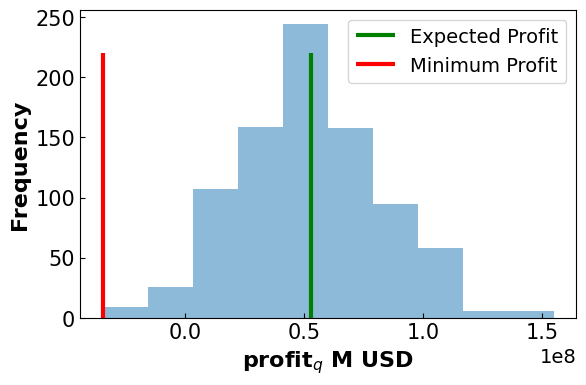

Results
-------------------------------------
Expected Profit: 52.92 M USD
Minimum Profit: -34.44 M USD
Difference: 87.36 M USD


In [ ]:
#Collect the profit distribution
profits = []
for i in m.price_time_obs:
    profits.append(pyo.value(m.profit[i]))

#Collect the minimum profit
min_prof = min(profits)

#Plot the Profit Distribution
fig, ax = plt.subplots(figsize=(6.4, 4))
plt.hist(np.array(profits), alpha = 0.5)
plt.vlines(ymin = 0,ymax= 220, x= pyo.value(m.EP), label = 'Expected Profit', color = 'green')
plt.vlines(ymin = 0, ymax = 220, x=min_prof, label = ('Minimum Profit'), color = 'red')
plt.xlabel('profit$_q$ M USD', fontsize = 16, fontweight='bold')
plt.ylabel('Frequency', fontsize = 16, fontweight='bold')
plt.legend(fontsize = 14)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.tick_params(direction="in")
plt.show()

print('Results')
print('-------------------------------------')
print('Expected Profit:', np.round(pyo.value(m.EP)/1e6,2), 'M USD')
print('Minimum Profit:', np.round(min_prof/1e6,2), 'M USD')
difference = pyo.value(m.EP) - min_prof
print('Difference:', np.round(difference/1e6,2), 'M USD')

#Collect results for conclusion
final_EP['MV'] = pyo.value(m.EP)/1e6
final_min['MV'] = min_prof/1e6
final_diff['MV'] = difference/1e6

#### Product Distribution

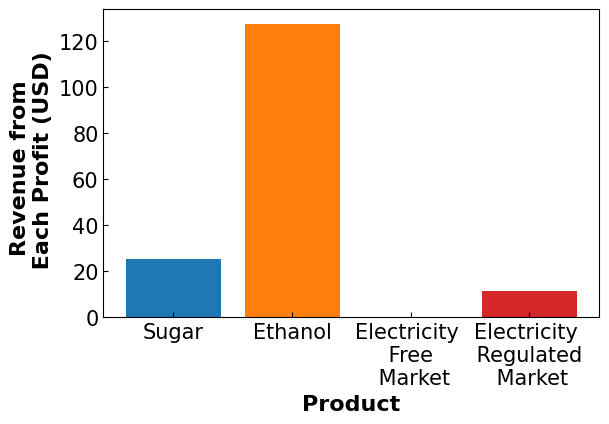

In [ ]:
fig, ax = plt.subplots(figsize=(6.4, 4))
plt.bar('Sugar',pyo.value(m.avg_sug_prof)/1e6)
plt.bar('Ethanol', pyo.value(m.avg_eth_prof)/1e6)
plt.bar('Electricity \n Free \n Market', pyo.value(m.avg_el_prof)/1e6)
plt.bar('Electricity \n Regulated \n Market', pyo.value(m.x['reg'])*72.5/1e6)
plt.xlabel('Product', fontsize = 16, fontweight = 'bold')
plt.ylabel('Revenue from \n Each Profit (USD)', fontsize = 16, fontweight='bold')
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.tick_params(direction="in")
plt.show()

### Formulate the MAD Objective

\begin{align*}
minimize \ \ MAD = E \left[ \mid \sum_{j=1}^{n} R_j x_j -E \left[ \sum_{j=1}^{n} R_j x_j \right] \mid \right]
\end{align*}


In [ ]:
#Reload the base Model
m = create_model()

#Create set of return indicies
J = np.arange(1,m.N)

#Create new variables
m.y_aux = pyo.Var(J, within = pyo.NonNegativeReals)
m.z_aux = pyo.Var(J, within = pyo.NonNegativeReals)

#Constrain y - z to be the abs portion
def aux_con(m,j):
    return m.y_aux[j] - m.z_aux[j] == sum(m.x[i]*(Returns.loc[j,i]-((1/m.N)*sum(Returns.loc[j,i] for j in J))) for i in m.commodities)
m.aux = pyo.Constraint(J, rule = aux_con)

#Define MAD as the objective
def mad(m):
    return 1/m.N * sum(m.y_aux[j] + m.z_aux[j] for j in J)
m.obj = pyo.Objective(rule = mad, sense = pyo.minimize)

#Solve the Model
sol =pyo.SolverFactory('ipopt')

results = sol.solve(m)

print('Results')
print('------------------------------')
print('Expected Profit', np.round(pyo.value(m.EP),2), 'USD')
print('Ethanol Produced', np.round(pyo.value(m.x['eth']),2), 'm3')
print('Sugar Produced', np.round(pyo.value(m.x['sug']),2), 'tonne')
print('Electricity Produced', np.round(pyo.value(m.x['el-r']),2), 'MWh')
print('Electricity to Free Market', np.round(pyo.value(m.x['fre']),2), 'MWh')
print('Electricity to Regulated Market', np.round(pyo.value(m.x['reg']),2), 'MWh')

Results
------------------------------
Expected Profit 51417964.31 USD
Ethanol Produced 163510.39 m3
Sugar Produced 166457.57 tonne
Electricity Produced 179341.69 MWh
Electricity to Free Market 1473.6 MWh
Electricity to Regulated Market 157526.4 MWh


### Visualize Results

#### Profit Distribution

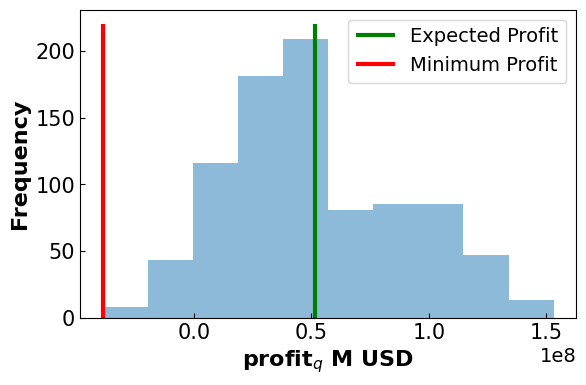

Results
-------------------------------------
Expected Profit: 51.42 M USD
Minimum Profit: -38.76 M USD
Difference: 90.18 M USD


In [ ]:
#Collect the profit distribution
profits = []
for i in m.price_time_obs:
    profits.append(pyo.value(m.profit[i]))

#Collect the minimum profit
min_prof = min(profits)

#Plot the Profit Distribution
fig, ax = plt.subplots(figsize=(6.4, 4))
plt.hist(np.array(profits), alpha = 0.5)
plt.vlines(ymin = 0,ymax= 220, x= pyo.value(m.EP), label = 'Expected Profit', color = 'green')
plt.vlines(ymin = 0, ymax = 220, x=min_prof, label = ('Minimum Profit'), color = 'red')
plt.xlabel('profit$_q$ M USD', fontsize = 16, fontweight='bold')
plt.ylabel('Frequency', fontsize = 16, fontweight='bold')
plt.legend(fontsize = 14)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.tick_params(direction="in")
plt.show()

print('Results')
print('-------------------------------------')
print('Expected Profit:', np.round(pyo.value(m.EP)/1e6,2), 'M USD')
print('Minimum Profit:', np.round(min_prof/1e6,2), 'M USD')
difference = pyo.value(m.EP) - min_prof
print('Difference:', np.round(difference/1e6,2), 'M USD')

#Collect results for conclusion
final_EP['MAD'] = pyo.value(m.EP)/1e6
final_min['MAD'] = min_prof/1e6
final_diff['MAD'] = difference/1e6

#### Product Distribution

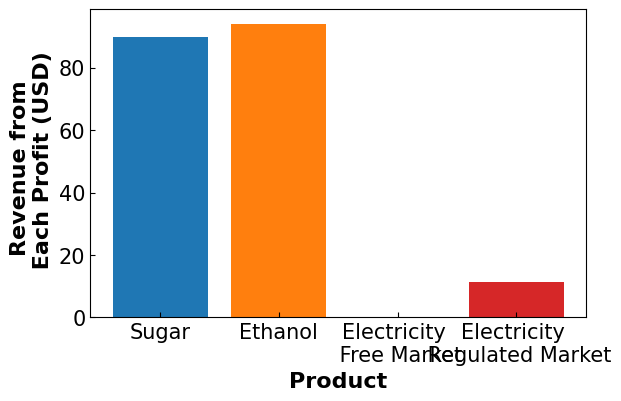

In [ ]:
fig, ax = plt.subplots(figsize=(6.4, 4))
plt.bar('Sugar',pyo.value(m.avg_sug_prof)/1e6)
plt.bar('Ethanol', pyo.value(m.avg_eth_prof)/1e6)
plt.bar('Electricity \n Free Market', pyo.value(m.avg_el_prof)/1e6)
plt.bar('Electricity \n Regulated Market', pyo.value(m.x['reg'])*72.5/1e6)
plt.xlabel('Product', fontsize=16, fontweight='bold')
plt.ylabel('Revenue from \n Each Profit (USD)', fontsize = 16, fontweight='bold')
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.tick_params(direction="in")
plt.show()

### Formulate the CVaR Objective

***Additional Parameters***
\begin{align*}
\alpha: VaR \\
\beta: Confidence\ Level
\end{align*}

***Additional Variables***
\begin{align*}
shortfall_{q}: Difference \ between \ VaR \ and \ profit_{q} \ at \ price \ scenario \ q\\
\end{align*}

***Additional Constraints***
\begin{align*}
shortfall_{q} \ \geq \ 0 \ \ \forall \ \ q \in Q \\
profit_{q} + shortfall_{q} - \alpha \geq 0 \ \ \forall \ \ q \in Q \\
CVaR = \alpha - \left[ \frac{1}{Q(1-\beta)} \sum_{q \in Q} shortfall_{q} \right] \\
\end{align*}

***CVaR Objective***
\begin{align*}
\max{CVaR}
\end{align*}

In [ ]:
#Reload the base Model
m = create_model()

#Add parameters
beta = 0.9 #confidence interval

#Add variables
m.shortfall = pyo.Var(m.price_time_obs)
m.alpha = pyo.Var()
m.CVaR = pyo.Var()

#Add CVaR Constraints
def CVaR1(m):
    return m.CVaR == m.alpha - ((1/(m.N*(1-beta)))*sum(m.shortfall[q] for q in m.price_time_obs))
m.cvar1eq = pyo.Constraint(rule = CVaR1)

def CVaR2(m,q):
    return m.shortfall[q] >= 0
m.cvar2eq = pyo.Constraint(m.price_time_obs, rule = CVaR2)

def CVaR4(m,q):
    return m.profit[q] + m.shortfall[q] - m.alpha >= 0
m.cvar4eq = pyo.Constraint(m.price_time_obs, rule = CVaR4)

#OBJECTIVE
def obj_rule(m):
    return m.CVaR
m.obj = pyo.Objective(rule=obj_rule, sense=pyo.maximize)

#Solve the Model
sol =pyo.SolverFactory('ipopt', tee = True)

results = sol.solve(m)

print('Results')
print('------------------------------')
print('Expected Profit', np.round(pyo.value(m.EP),2), 'USD')
print('Ethanol Produced', np.round(pyo.value(m.x['eth']),2), 'm3')
print('Sugar Produced', np.round(pyo.value(m.x['sug']),2), 'tonne')
print('Electricity Produced', np.round(pyo.value(m.x['el-r']),2), 'MWh')
print('Electricity to Free Market', np.round(pyo.value(m.x['fre']),2), 'MWh')
print('Electricity to Regulated Market', np.round(pyo.value(m.x['reg']),2), 'MWh')

Results
------------------------------
Expected Profit 63732508.16 USD
Ethanol Produced 140078.89 m3
Sugar Produced 164381.0 tonne
Electricity Produced 156465.59 MWh
Electricity to Free Market 0.0 MWh
Electricity to Regulated Market 159000.0 MWh


### Visualize Results

#### Profit Distribution

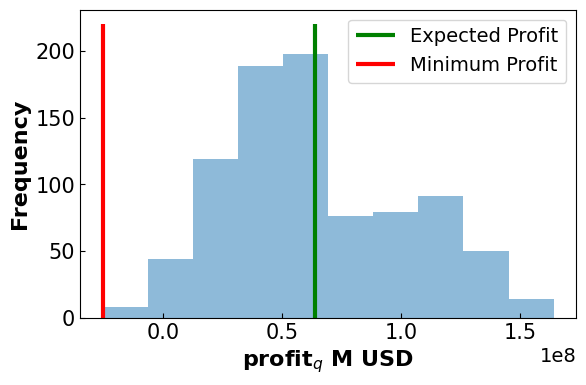

Results
-------------------------------------
Expected Profit: 63.73 M USD
Minimum Profit: -25.4 M USD
Difference: 89.13 M USD


In [ ]:
#Collect the profit distribution
profits = []
for i in m.price_time_obs:
    profits.append(pyo.value(m.profit[i]))

#Collect the minimum profit
min_prof = min(profits)

#Plot the Profit Distribution
fig, ax = plt.subplots(figsize=(6.4, 4))
plt.hist(np.array(profits), alpha = 0.5)
plt.vlines(ymin = 0,ymax= 220, x= pyo.value(m.EP), label = 'Expected Profit', color = 'green')
plt.vlines(ymin = 0, ymax = 220, x=min_prof, label = ('Minimum Profit'), color = 'red')
plt.xlabel('profit$_q$ M USD', fontsize = 16, fontweight='bold')
plt.ylabel('Frequency', fontsize = 16, fontweight='bold')
plt.legend(fontsize = 14)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.tick_params(direction="in")
plt.show()

print('Results')
print('-------------------------------------')
print('Expected Profit:', np.round(pyo.value(m.EP)/1e6,2), 'M USD')
print('Minimum Profit:', np.round(min_prof/1e6,2), 'M USD')
difference = pyo.value(m.EP) - min_prof
print('Difference:', np.round(difference/1e6,2), 'M USD')

#Collect results for conclusion
final_EP['CVaR'] = pyo.value(m.EP)/1e6
final_min['CVaR'] = min_prof/1e6
final_diff['CVaR'] = difference/1e6

#### Product Distribution

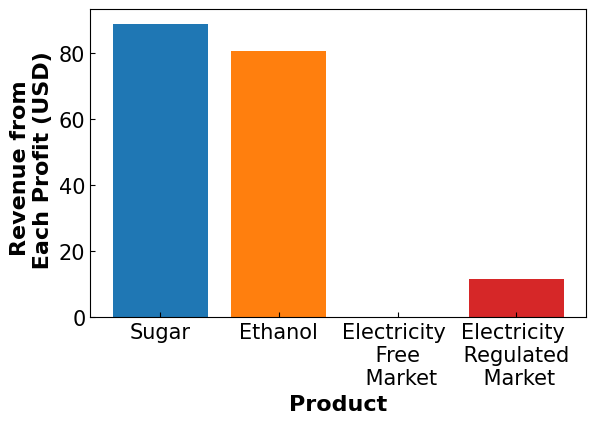

In [ ]:
fig, ax = plt.subplots(figsize=(6.4, 4))
plt.bar('Sugar',pyo.value(m.avg_sug_prof)/1e6)
plt.bar('Ethanol', pyo.value(m.avg_eth_prof)/1e6)
plt.bar('Electricity \n Free \n Market', pyo.value(m.avg_el_prof)/1e6)
plt.bar('Electricity \n Regulated \n Market', pyo.value(m.x['reg'])*72.5/1e6)
plt.ylabel('Revenue from \n Each Profit (USD)', fontsize = 16, fontweight='bold')
plt.xlabel('Product', fontsize = 16, fontweight = 'bold')
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.tick_params(direction="in")
plt.show()

## Conclusion

### Final Results Comparison

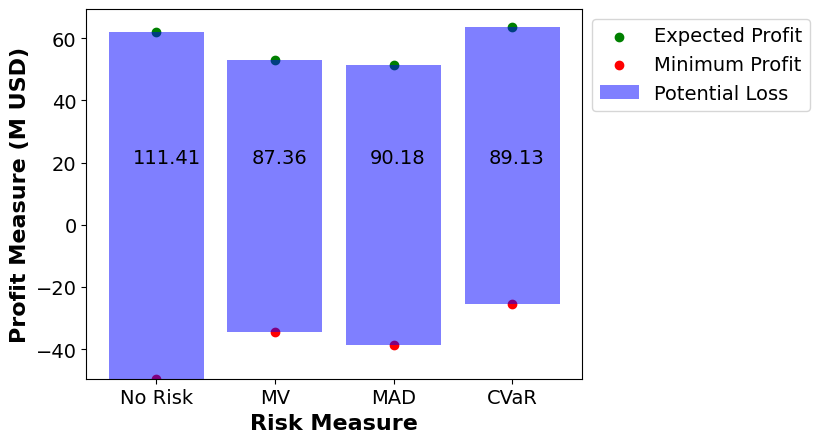

In [ ]:
k=0
for i in final_EP.keys():
    if k < 0.5:
        plt.scatter(i,final_EP[i], color = 'green',label = 'Expected Profit')
        plt.scatter(i,final_min[i], color = 'red', label = 'Minimum Profit')
        plt.bar(i,final_diff[i], color = 'blue', alpha = 0.5, bottom = final_min[i], label = 'Potential Loss')
        plt.text(k-0.2,20, np.round(final_diff[i],2), fontsize = 14)
    else:
        plt.scatter(i,final_EP[i], color = 'green')
        plt.scatter(i,final_min[i], color = 'red')
        plt.bar(i,final_diff[i], color = 'blue', alpha = 0.5, bottom = final_min[i])
        plt.text(k-0.2,20, np.round(final_diff[i],2), fontsize = 14)
    k = k+1

ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.tick_params(direction="in")
plt.legend(bbox_to_anchor=(1, 1),fontsize = 14)
plt.xlabel('Risk Measure' ,fontsize  = 16, fontweight = 'bold')
plt.ylabel('Profit Measure (M USD)', fontsize  = 16, fontweight = 'bold')
plt.show()

## References

<div class="csl-entry"> [1] Gunjan, A., &#38; Bhattacharyya, S. (2022). A brief review of portfolio optimization techniques. <i>Artificial Intelligence Review</i>. https://doi.org/10.1007/s10462-022-10273-7</div>

<div class="csl-entry"> [2] Markowitz, H. (1959). Portfolio selection, efficient diversification of investments. Wiley, New York

<div class="csl-entry"> [3] Konno, H., &#38; Koshizuka, T. (2005). Mean-absolute deviation model. <i>IIE Transactions (Institute of Industrial Engineers)</i>, <i>37</i>(10), 893–900. https://doi.org/10.1080/07408170591007786</div>

<div class="csl-entry"> [4] Mutran, V. M., Ribeiro, C. O., Nascimento, C. A. O., &#38; Chachuat, B. (2020). Risk-conscious optimization model to support bioenergy investments in the Brazilian sugarcane industry. <i>Applied Energy</i>, <i>258</i>. https://doi.org/10.1016/j.apenergy.2019.113978</div>

<div class="csl-entry"> [5] Li, L., Lin, J., Wu, N., Xie, S., Meng, C., Zheng, Y., Wang, X., &#38; Zhao, Y. (2022). Review and outlook on the international renewable energy development. In <i>Energy and Built Environment</i> (Vol. 3, Issue 2, pp. 139–157). KeAi Communications Co. https://doi.org/10.1016/j.enbenv.2020.12.002</div>

<div class="csl-entry"> [6] Oliveira, S. M. de, Ribeiro, C. de O., &#38; Cicogna, M. P. V. (2018). Uncertainty effects on production mix and on hedging decisions: The case of Brazilian ethanol and sugar. <i>Energy Economics</i>, <i>70</i>, 516–524. https://doi.org/10.1016/j.eneco.2018.01.025</div>

# The Base Problem
Our work expands upon the notebook prepared by Madelyn Watson for Portfolio management.  It includes the Mean Value (MV), Mean-Absolute Deviation, and Condition Value-at-Risk (CVaR) risk measurements, taken directly from Madelyn's work.  For a summary of those risk measurements, We have included the equations from her work, though for greater analysis, the source notebook is excellent.  The base idea is that a Sugar Cane mill in Brazil must decide how to process its products into sugar cane, ethanol, and free market and regulated electricity.  With different risk management metrics comes different profiles, though interesting results do follow with the inclusion of more complicated scenarios.  Below is the mill flowchart prepared in the original notebook, describing the system and decision tree, of sorts.

![op1.jpg](https://raw.githubusercontent.com/ndcbe/optimization/main/media/contrib/process_PFD.jpg)

## Risk measurement equations
**MV**
\begin{align*}
MV = \sum_{i=1}^{n} \sum_{j=1}^{n} \sigma_{i,j} x_i x_j
\end{align*}

**MAD**
\begin{align*}
MAD = E \left[ \mid \sum_{j=1}^{n} R_j x_j -E \left[ \sum_{j=1}^{n} R_j x_j \right] \mid \right]
\end{align*}

**CVaR**
\begin{align*}
VaR_{\beta} = \max V \\
s.t.  \sum_{j=1}^{N} 1 \left[ V - R_j \right] \leq (1-\beta)N
\end{align*}

\begin{align*}
CVaR_{\beta} = VaR_{\beta} - \frac{1}{(1-\beta)N}  \sum_{j=1}^{N} max \left[ 0, VaR_{\beta} - R_j \right]
\end{align*}



##Implementing a new scenario: model supply and demand and government caps

Say the historical prices are only averages and the true reality is that the market supply and demand curves are more active.  Specifically, this imiplies that the market prices provided are anchor prices, but the true profit a certain mill recieves is functionally dependent on the amount produced.

Generally, supply and demand curves can take any one of a variety of functional forms relating production/quantity and price, but for the sake of not repeating stale analysis, we primarily considered a linearly decreasing market price.  The actual total profit requires that the production curve be integrated from 0 to the amount produced, but this amount is unknown and dependent on the optimization, so pyomo cannot handle an implicit integration system- normally, this would require a lambda function-type code or a significant nondimensionalization reformatting.  Alternatively, the sale prices could be binned, with a more precise integral resulting from more bins (with the accompanying increase in computational cost from a larger number of variables).  This approach was utilized.  The bins used a left-side rule, so the bin approximation of a true integral is larger than a middle-point rule or the true integral itself, but this is more reasonable from a real-life scenario, since the maximum price in any real-life binning scenario would be applied to the top bin instead of some estimated median value.  The equation used is listed in the profit calculations section below.

There are 2 ways to initiate the model: either use the historical data as a middle point somewhere along the curve, or use the historical data as the demand cost for 1 unit.  We believe it is impossible to provide any practical justification for the former strategy, since it is unclear where along the curve that anchor should be placed without knowing how much will be produced.  We could use the previous optimization solution, but it is still unclear how aggressive to be in this design.  Since we are already designing the functions ourselves, we decided to focus any hypothetical on this.

We ensured that the market price is still positive for all values that could be produced using the mill capacity, but that if the mill produced too much sugar, it would start to lose money at some point.  The aggressiveness of this decay is a hyperparameter that effectively determines the floor price of sugar (which is named in our parameter set), though the effect on production of a more aggressive regime is easily deduced from the a baseline decay regime.

We also applied a maximum cap on the amount of electricity that could possibly go to the regulated market, assuming that some government regulation would limit the amount that could be sold there.  This is a farily simple change, but it does increase the considerations that the system must work with.

## System Description/Model
***Sets***
\begin{align*}
r \in R: &\ \text{Resources} \\
s \in S: &\ \text{Saleable Products} \\
u \in U: &\ \text{Process Units} \\
c \in C: &\ \text{Commodities} \\
q \in Q: &\ \text{Historical Price Scenarios} \\
b \in B: &\ \text{Sugar in all Bins}
\end{align*}

***Parameters***
\begin{align*}
Ca: Yearly\ production\ of\ sugarcane \\
\tau_{u}: Maximum\ capacity\ of\ process\ unit\ u \\
PC_{s}: Production\ cost\ of\ saleable\ product\ s \\
\theta_{f,u,p}: Conversion\ of\ resource\ f\ in\ process\ unit\ u\ to\ product\ p \\
\gamma_{u,p}: Generation\ of\ product\ p\ in\ unit\ u \\
HP_{q,c}: Historical\ Prices\ at\ price\ scenario\ q\\
\pi_{reg}: Price \ of \ electricity \ at \ the \ regulated \ market \\
\ n_{bins}: Number \ of \ integration \ bins \\
\ P_{floor}: Floor \ price \ of \ sugar \ cane \\
\ sug_{max}: Maximum \ amount \ of \ sugar \ produced \\
\end{align*}

***Variables***
\begin{align*}
x_{p}: Amount\ of\ product\ p \\
profit_{q}: Profit\ for\ each\ historical\ price\ scenario\ q\\
Eprofit: Expected\ value\ of\ the\ profit \\
y_{b}: Amount \ of \ sugar \ in \ bin \ b
\end{align*}

***Constraints***

*Mass Balances*
\begin{align*}
x_{jui} = Ca \cdot \theta_{cane,mill,jui} \\
x_{bag} = Ca \cdot \theta_{cane,mill,bag} \\
x_{jui} = x_{jui-fact} + x_{jui-dist} \\
x_{sug} = x_{jui-fact} \cdot \theta_{jui,fact,sug} \\
x_{mol} = x_{sug} \cdot \gamma_{mol,fact} \\
x_{eth} = x_{jui-dist} \cdot \theta_{jui,dist,eth} + x_{mol} \cdot \theta_{mol,dist,eth} \\
x_{reg} + x_{free} = x_{el-r} \\
\sum_{b \in B} y_{b} = x_{sug} \\
\ y_{b} \leq \frac{sug_{max}}{n_{bins}} \\
\end{align*}

**Additional Electricity Constraint**
\begin{align*}
&{\text{el_reg}} \leq 100000 \ MWh \\
\end{align*}

**Profit Calculations**
\begin{align*}
profit_{q} = \sum_{c \in C not sugar} x_{p} \cdot HP_{q,c} + f(x_{sug},HP_{q,sug}) + x_{reg} \cdot \pi_{reg} - \sum_{s \in S} x_{s} \cdot PC_{s} \ \ \forall \ \ q \in Q\\
f(x_{sug},HP_{q,sug}) = \sum_{b \in B} y_{b}*(HP_{q,sug} - (1-\frac{b}{n_{bins}})*(HP_{q,sug}- P_{floor}))\\
Eprofit = \frac{1}{Q} \sum_{q \in Q} profit_{q} \\
\end{align*}

## DOF Analysis
**Number of Variables**
\begin{align*}
x_{p} \cdot 10 \ products \\
y_{b} \cdot n_{bins} \ bins\\
n_{bins} \cdot 1 \\
profit_{Q} \cdot Q \\
Eproft \cdot 1 \\
Total\ Variables = 10 + n_{bins} + 1 + Q + 1
\end{align*}

**Number of Constraints**
\begin{align*}
7 \ mass \ balances \\
\ bin \ constraints \cdot n_{bins}\\
\ bin \ sum \cdot 1 \\
profit \ scenarios \cdot Q \\
Eproft \cdot 1 \\
Total\ Constraints = 7 + n_{bins} + 1 + Q + 1
\end{align*}

**DOF**
\begin{align*}
DOF = Variables - Constraints \\
DOF = 10 + n_{bins} + 1 + Q + 1 - 7 - n_{bins} - 1 - Q - 1 \\
DOF = 3
\end{align*}

In [1]:
#Create Base Model In Pyomo
def get_prodCost(i):
  og_price = df_prodcost['cost'][i]
  cost_uncertainty = np.random.uniform(0.85, 1.15)
  return og_price*cost_uncertainty
def create_model(scale_hyp=0.5,bin_count=200):
    '''
    This function buils a superstructure model in Pyomo for a sugarcane mill that can produce jet fuel.

    Inputs:
            product: desired product to maximize
            pathway: Excel sheet containing Jet fuel

    Returns: Pyomo model m
    '''
    m=pyo.ConcreteModel()

    #SETS
    resources = ['sug', 'eth', 'fre', 'reg', 'cane', 'jui', 'mol', 'bag', 'el-r']
    saleable_products = ['sug', 'eth', 'fre', 'reg']
    processes = ['mill', 'fact', 'dist','cogen']
    commodity = ['fre','sug','eth']

    #PARAMETERS
    #Scalars
    Ca = 3000000  # Annual Sugarcane Capacity
    beta = 0.9   # Confidence Level For CVaR Formulation
    price_reg = 72.5   # Price of electricity sold to the regulated market

    bin_width = [1541400/bin_count for i in range(bin_count)]
    bins = [0 for i in range(bin_count)]
    bin_indices = [i for i in range(bin_count)]

    #Fill in Dictionaries with Excel Data
    max_cap = {}
    prodcost = {}
    conv = {}
    gen = {}
    hp = {}

    for i in range(len(df_maxcap['process'])):
        max_cap[df_maxcap['process'][i]] = df_maxcap['capacity'][i]

    for i in range(len(df_prodcost['saleable_product'])):
        prodcost[df_prodcost['saleable_product'][i]] = get_prodCost(i)
    for k in resources:
        for i in range(len(df_conv[k])):
            conv[(df_conv['resource'][i],df_conv['process'][i],k)] = df_conv[k][i]

    for k in resources:
        for i in range(len(df_gen[k])):
            gen[(df_gen['process'][i],k)] = df_gen[k][i]

    for k in commodity:
        for i in range(len(df_hp[k])):
            hp[(df_hp['q'][i],k)] = df_hp[k][i]

    N = len(df_hp['q'])
    q=[]
    for i in range(1,N+1):
        q.append('t%d' %(i))

    #PYOMO SETS
    m.resources = pyo.Set(initialize = resources)
    m.saleable_products = pyo.Set(initialize = saleable_products)
    m.processes = pyo.Set(initialize = processes)
    m.price_time_obs = pyo.Set(initialize = q)
    m.commodities = pyo.Set(initialize = commodity)

    m.N = pyo.Param(initialize = N)

    #VARIABLES
    #Positive Variables
    m.x = pyo.Var(m.resources, within = pyo.NonNegativeReals)
    m.r = pyo.Var(m.resources,m.processes, within = pyo.NonNegativeReals) #For juice split point
    m.profit = pyo.Var(m.price_time_obs)
    m.EP = pyo.Var()
    m.S_bins = pyo.Var(bin_indices,within=pyo.NonNegativeReals)

    # Adding randomness in yield ranging from -20% to +20%
    yield_factors = np.random.uniform(0.8, 1.2, 6)
    jui_yield, bag_yield, sug_yield, mol_yield, el_yield, eth_yield = yield_factors

    #CONSTRAINTS
    #Superstructure Constraints
    def mill1(m):
        return m.x['jui']*jui_yield == Ca * conv['cane','mill','jui']
    m.milleq1 = pyo.Constraint(rule = mill1)

    def mill2(m):
        return m.x['bag']*bag_yield == Ca * conv['cane','mill','bag']
    m.milleq2 = pyo.Constraint(rule = mill2)

    def juice1(m):
        return m.x['jui']*jui_yield == m.r['jui','fact'] + m.r['jui','dist']
    m.juiceeq1 = pyo.Constraint(rule = juice1)

    def juice2(m):
        return m.r['jui','fact'] <= max_cap['fact']
    m.juiceeq2 = pyo.Constraint(rule = juice2)

    def juice3(m):
        return m.r['jui','dist'] <= max_cap['dist']
    m.juiceeq3 = pyo.Constraint(rule = juice3)

    def sugar1(m):
        return m.x['sug']*sug_yield == conv['jui', 'fact', 'sug'] * m.r['jui','fact']
    m.su1 = pyo.Constraint(rule = sugar1)

    def sugar2(m):
        return m.x['mol']*mol_yield == gen['fact','mol'] * m.x['sug']
    m.su2 = pyo.Constraint(rule = sugar2)

    def ethanol1(m):
        return m.x['eth']*eth_yield == conv['jui','dist','eth'] * m.r['jui','dist'] + conv['mol','dist','eth']*m.x['mol']
    m.et1 = pyo.Constraint(rule = ethanol1)

    def el_prod(m):
        return m.x['el-r']*el_yield == Ca * 0.053 #53 kWh produced per ton of sugarcane processes
    m.el_produced = pyo.Constraint(rule = el_prod)

    def el_sales(m):
        return m.x['fre'] + m.x['reg'] == m.x['el-r']*el_yield
    m.electricity = pyo.Constraint(rule = el_sales)

    # sugar cane reformulation
    def sugar_sum(m):
        return m.x['sug'] == sum(m.S_bins[i] for i in range(bin_count))
    m.sugar_tot_sum = pyo.Constraint(rule=sugar_sum)

    for i in range(bin_count):
        m.add_component(f'bin_{i+1}_max',pyo.Constraint(expr=m.S_bins[i] <= bin_width[i]))

    # Cap on regulated electricity
    def el_reg_cap(m):
        return m.x['reg'] <= 100000
    m.reg_cap = pyo.Constraint(rule=el_reg_cap)

    #Expected Profit
    def profit(m,q):
        return m.profit[q] == sum(m.S_bins[z]*(hp[q,'sug']-(hp[q,'sug']-scale_hyp*321.92)*(bin_count-z)/bin_count) for z in range(bin_count)) + eth_yield*m.x['eth']*hp[q,'eth'] + m.x['fre']*hp[q,'fre'] + m.x['reg']*price_reg - sum(m.x[j]*prodcost[j] for j in m.saleable_products)
    m.profiteq = pyo.Constraint(m.price_time_obs, rule = profit)

    def eprofit1(m):
        return m.EP == (1/N)*sum(m.profit[q] for q in m.price_time_obs)
    m.ep1 = pyo.Constraint(rule = eprofit1)

    #Product Revenues to be used in analysis
    def sug_prof(m):
        return sum(sum(m.S_bins[z]*(hp[q,'sug']-(hp[q,'sug']-2/3*321.92)*(bin_count-z)/bin_count) for z in range(bin_count)) for q in m.price_time_obs) * (1/N)
    m.avg_sug_prof = pyo.Expression(rule = sug_prof)

    def eth_prof(m):
        return sum(m.x['eth']*hp[q,'eth'] for q in m.price_time_obs) * (1/N)
    m.avg_eth_prof = pyo.Expression(rule = eth_prof)

    def el_prof(m):
        return sum(m.x['fre']*hp[q,'fre'] for q in m.price_time_obs) * (1/N)
    m.avg_el_prof = pyo.Expression(rule = el_prof)

    return m

In [12]:
#Reload the base Model
m = create_model()

#Drop the scenario number column
price = df_hp.drop(columns = ['q'])

#Calculate Returns
Returns = price.diff()/price.shift(1)

covar = Returns.cov()
print('Covariance Matrix')
print('-------------------')
print(covar)

#Define MV as the objective
def mean_value(m):
    return sum(m.x[i]*covar.loc[i,j]*m.x[j] for i in m.commodities for j in m.commodities)
m.obj = pyo.Objective(rule = mean_value, sense = pyo.minimize)

#Solve the Model
sol =pyo.SolverFactory('ipopt')

sol.solve(m)

print('Results')
print('--------------------------------------')
print('Expected Profit', np.round(pyo.value(m.EP),2), 'USD')
print('Ethanol Produced', np.round(pyo.value(m.x['eth']),2), 'm3')
print('Sugar Produced', np.round(pyo.value(m.x['sug']),2), 'tonne')
print('Electricity Produced', np.round(pyo.value(m.x['el-r']),2), 'MWh')
print('Electricity to Free Market', np.round(pyo.value(m.x['fre']),2), 'MWh')
print('Electricity to Regulated Market', np.round(pyo.value(m.x['reg']),2), 'MWh')


Covariance Matrix
-------------------
          fre       sug       eth
fre  0.094993 -0.000350 -0.000756
sug -0.000350  0.000922  0.000390
eth -0.000756  0.000390  0.001578
Results
--------------------------------------
Expected Profit 36112295.06 USD
Ethanol Produced 198712.66 m3
Sugar Produced 74934.61 tonne
Electricity Produced 145171.14 MWh
Electricity to Free Market 59000.0 MWh
Electricity to Regulated Market 100000.0 MWh


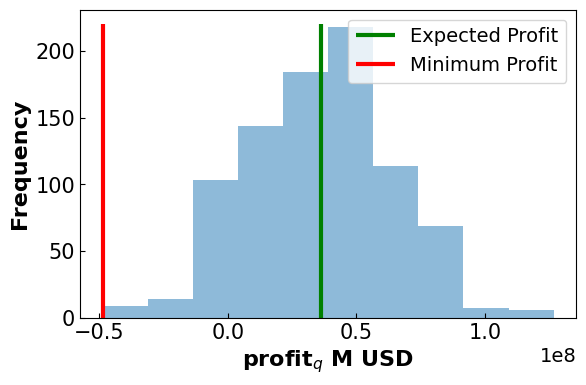

Results
-------------------------------------
Expected Profit: 36.11 M USD
Minimum Profit: -48.59 M USD
Difference: 84.7 M USD


In [13]:
#Collect the profit distribution
profits = []
for i in m.price_time_obs:
    profits.append(pyo.value(m.profit[i]))

#Collect the minimum profit
min_prof = min(profits)

#Plot the Profit Distribution
fig, ax = plt.subplots(figsize=(6.4, 4))
plt.hist(np.array(profits), alpha = 0.5)
plt.vlines(ymin = 0,ymax= 220, x= pyo.value(m.EP), label = 'Expected Profit', color = 'green')
plt.vlines(ymin = 0, ymax = 220, x=min_prof, label = ('Minimum Profit'), color = 'red')
plt.xlabel('profit$_q$ M USD', fontsize = 16, fontweight='bold')
plt.ylabel('Frequency', fontsize = 16, fontweight='bold')
plt.legend(fontsize = 14)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.tick_params(direction="in")
plt.show()

print('Results')
print('-------------------------------------')
print('Expected Profit:', np.round(pyo.value(m.EP)/1e6,2), 'M USD')
print('Minimum Profit:', np.round(min_prof/1e6,2), 'M USD')
difference = pyo.value(m.EP) - min_prof
print('Difference:', np.round(difference/1e6,2), 'M USD')

#Collect results for conclusion
#final_EP['MV'] = pyo.value(m.EP)/1e6
#final_min['MV'] = min_prof/1e6
#final_diff['MV'] = difference/1e6

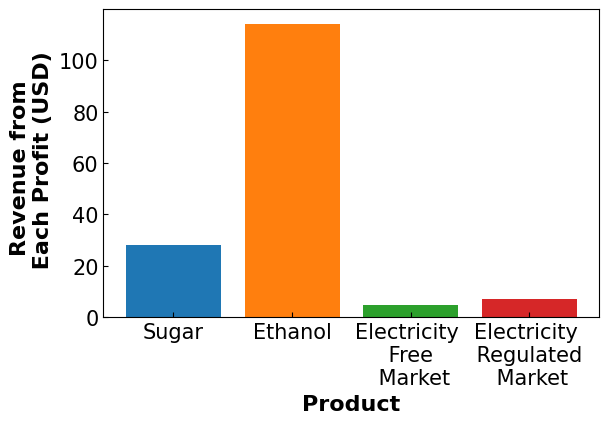

In [14]:
fig, ax = plt.subplots(figsize=(6.4, 4))
plt.bar('Sugar',pyo.value(m.avg_sug_prof)/1e6)
plt.bar('Ethanol', pyo.value(m.avg_eth_prof)/1e6)
plt.bar('Electricity \n Free \n Market', pyo.value(m.avg_el_prof)/1e6)
plt.bar('Electricity \n Regulated \n Market', pyo.value(m.x['reg'])*72.5/1e6)
plt.ylabel('Revenue from \n Each Profit (USD)', fontsize = 16, fontweight='bold')
plt.xlabel('Product', fontsize = 16, fontweight = 'bold')
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.tick_params(direction="in")
plt.show()

In [ ]:
#Reload the base Model
m = create_model()

#Create set of return indicies
J = np.arange(1,m.N)

#Create new variables
m.y_aux = pyo.Var(J, within = pyo.NonNegativeReals)
m.z_aux = pyo.Var(J, within = pyo.NonNegativeReals)

#Constrain y - z to be the abs portion
def aux_con(m,j):
    return m.y_aux[j] - m.z_aux[j] == sum(m.x[i]*(Returns.loc[j,i]-((1/m.N)*sum(Returns.loc[j,i] for j in J))) for i in m.commodities)
m.aux = pyo.Constraint(J, rule = aux_con)

#Define MAD as the objective
def mad(m):
    return 1/m.N * sum(m.y_aux[j] + m.z_aux[j] for j in J)
m.obj = pyo.Objective(rule = mad, sense = pyo.minimize)

#Solve the Model
sol =pyo.SolverFactory('ipopt')

results = sol.solve(m)

print('Results')
print('------------------------------')
print('Expected Profit', np.round(pyo.value(m.EP),2), 'USD')
print('Ethanol Produced', np.round(pyo.value(m.x['eth']),2), 'm3')
print('Sugar Produced', np.round(pyo.value(m.x['sug']),2), 'tonne')
print('Electricity Produced', np.round(pyo.value(m.x['el-r']),2), 'MWh')
print('Electricity to Free Market', np.round(pyo.value(m.x['fre']),2), 'MWh')
print('Electricity to Regulated Market', np.round(pyo.value(m.x['reg']),2), 'MWh')

Results
------------------------------
Expected Profit 32816123.39 USD
Ethanol Produced 210444.28 m3
Sugar Produced 90052.78 tonne
Electricity Produced 149898.17 MWh
Electricity to Free Market 59000.0 MWh
Electricity to Regulated Market 100000.0 MWh


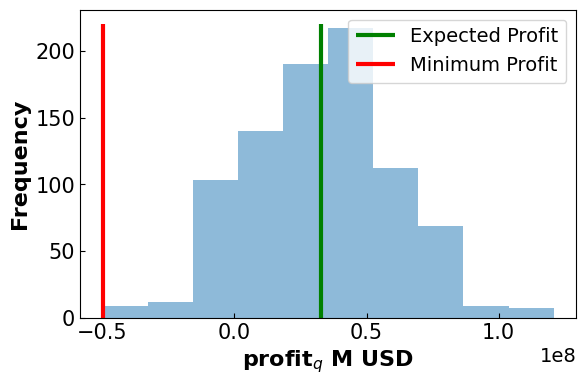

Results
-------------------------------------
Expected Profit: 32.82 M USD
Minimum Profit: -49.84 M USD
Difference: 82.66 M USD


In [ ]:
#Collect the profit distribution
profits = []
for i in m.price_time_obs:
    profits.append(pyo.value(m.profit[i]))

#Collect the minimum profit
min_prof = min(profits)

#Plot the Profit Distribution
fig, ax = plt.subplots(figsize=(6.4, 4))
plt.hist(np.array(profits), alpha = 0.5)
plt.vlines(ymin = 0,ymax= 220, x= pyo.value(m.EP), label = 'Expected Profit', color = 'green')
plt.vlines(ymin = 0, ymax = 220, x=min_prof, label = ('Minimum Profit'), color = 'red')
plt.xlabel('profit$_q$ M USD', fontsize = 16, fontweight='bold')
plt.ylabel('Frequency', fontsize = 16, fontweight='bold')
plt.legend(fontsize = 14)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.tick_params(direction="in")
plt.show()

print('Results')
print('-------------------------------------')
print('Expected Profit:', np.round(pyo.value(m.EP)/1e6,2), 'M USD')
print('Minimum Profit:', np.round(min_prof/1e6,2), 'M USD')
difference = pyo.value(m.EP) - min_prof
print('Difference:', np.round(difference/1e6,2), 'M USD')

#Collect results for conclusion
final_EP['MAD'] = pyo.value(m.EP)/1e6
final_min['MAD'] = min_prof/1e6
final_diff['MAD'] = difference/1e6

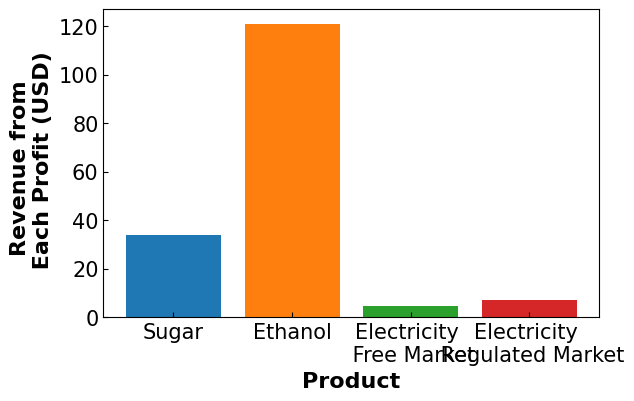

In [ ]:
fig, ax = plt.subplots(figsize=(6.4, 4))
plt.bar('Sugar',pyo.value(m.avg_sug_prof)/1e6)
plt.bar('Ethanol', pyo.value(m.avg_eth_prof)/1e6)
plt.bar('Electricity \n Free Market', pyo.value(m.avg_el_prof)/1e6)
plt.bar('Electricity \n Regulated Market', pyo.value(m.x['reg'])*72.5/1e6)
plt.xlabel('Product', fontsize=16, fontweight='bold')
plt.ylabel('Revenue from \n Each Profit (USD)', fontsize = 16, fontweight='bold')
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.tick_params(direction="in")
plt.show()

In [19]:
#Reload the base Model
m = create_model()

#Add parameters
beta = 0.9 #confidence interval

#Add variables
m.shortfall = pyo.Var(m.price_time_obs)
m.alpha = pyo.Var()
m.CVaR = pyo.Var()

#Add CVaR Constraints
def CVaR1(m):
    return m.CVaR == m.alpha - ((1/(m.N*(1-beta)))*sum(m.shortfall[q] for q in m.price_time_obs))
m.cvar1eq = pyo.Constraint(rule = CVaR1)

def CVaR2(m,q):
    return m.shortfall[q] >= 0
m.cvar2eq = pyo.Constraint(m.price_time_obs, rule = CVaR2)

def CVaR4(m,q):
    return m.profit[q] + m.shortfall[q] - m.alpha >= 0
m.cvar4eq = pyo.Constraint(m.price_time_obs, rule = CVaR4)

#OBJECTIVE
def obj_rule(m):
    return m.CVaR
m.obj = pyo.Objective(rule=obj_rule, sense=pyo.maximize)

#Solve the Model
sol =pyo.SolverFactory('ipopt')

results = sol.solve(m)

print('Results')
print('------------------------------')
print('Expected Profit', np.round(pyo.value(m.EP),2), 'USD')
print('Ethanol Produced', np.round(pyo.value(m.x['eth']),2), 'm3')
print('Sugar Produced', np.round(pyo.value(m.x['sug']),2), 'tonne')
print('Electricity Produced', np.round(pyo.value(m.x['el-r']),2), 'MWh')
print('Electricity to Free Market', np.round(pyo.value(m.x['fre']),2), 'MWh')
print('Electricity to Regulated Market', np.round(pyo.value(m.x['reg']),2), 'MWh')

Results
------------------------------
Expected Profit 56713844.63 USD
Ethanol Produced 156150.13 m3
Sugar Produced 209837.2 tonne
Electricity Produced 152632.76 MWh
Electricity to Free Market 59000.0 MWh
Electricity to Regulated Market 100000.0 MWh


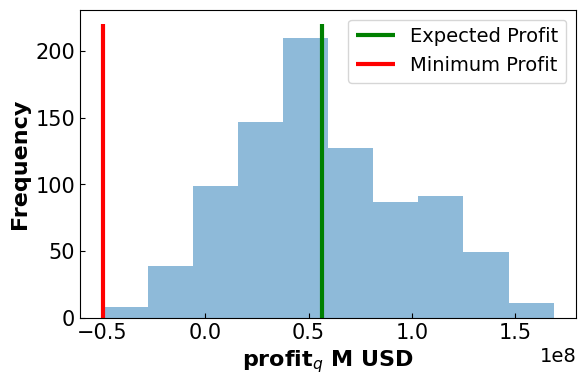

Results
-------------------------------------
Expected Profit: 56.71 M USD
Minimum Profit: -49.49 M USD
Difference: 106.21 M USD


In [20]:
#Collect the profit distribution
profits = []
for i in m.price_time_obs:
    profits.append(pyo.value(m.profit[i]))

#Collect the minimum profit
min_prof = min(profits)

#Plot the Profit Distribution
fig, ax = plt.subplots(figsize=(6.4, 4))
plt.hist(np.array(profits), alpha = 0.5)
plt.vlines(ymin = 0,ymax= 220, x= pyo.value(m.EP), label = 'Expected Profit', color = 'green')
plt.vlines(ymin = 0, ymax = 220, x=min_prof, label = ('Minimum Profit'), color = 'red')
plt.xlabel('profit$_q$ M USD', fontsize = 16, fontweight='bold')
plt.ylabel('Frequency', fontsize = 16, fontweight='bold')
plt.legend(fontsize = 14)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.tick_params(direction="in")
plt.show()

print('Results')
print('-------------------------------------')
print('Expected Profit:', np.round(pyo.value(m.EP)/1e6,2), 'M USD')
print('Minimum Profit:', np.round(min_prof/1e6,2), 'M USD')
difference = pyo.value(m.EP) - min_prof
print('Difference:', np.round(difference/1e6,2), 'M USD')

#Collect results for conclusion
#final_EP['CVaR'] = pyo.value(m.EP)/1e6
#final_min['CVaR'] = min_prof/1e6
#final_diff['CVaR'] = difference/1e6

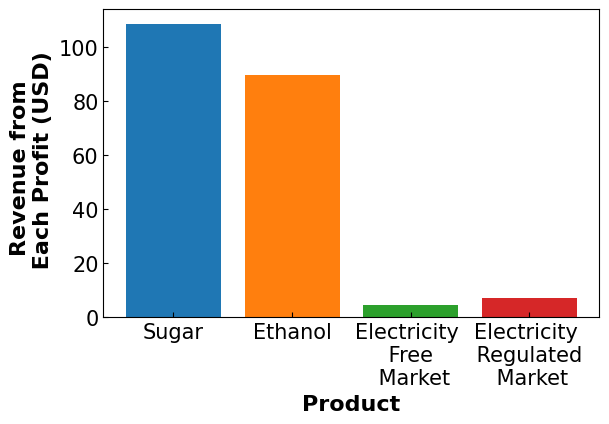

In [21]:
ig, ax = plt.subplots(figsize=(6.4, 4))
plt.bar('Sugar',pyo.value(m.avg_sug_prof)/1e6)
plt.bar('Ethanol', pyo.value(m.avg_eth_prof)/1e6)
plt.bar('Electricity \n Free \n Market', pyo.value(m.avg_el_prof)/1e6)
plt.bar('Electricity \n Regulated \n Market', pyo.value(m.x['reg'])*72.5/1e6)
plt.ylabel('Revenue from \n Each Profit (USD)', fontsize = 16, fontweight='bold')
plt.xlabel('Product', fontsize = 16, fontweight = 'bold')
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.tick_params(direction="in")
plt.show()

## Summarizing what happened
It isn't always easy to see what happened differently, but there are a few things to note.  First, the amount of profit from Sugar sold to market decreased significantly using the MAD objective, but not the MV objective.  This suggests the difference in priority carries over between targets, but the sugar profit still gets capped and effects the overall portfolio in certain circumstances.  Second, as expected the electricity to the free market increases to compensate for the regulated market cap.  Nothing particularly special there, but it is a good sanity check that the algorithm is functioning as intended.  Finally, it should be noted that profit is down overall for all metrics- as expected.

## Implementing a new scenario: stochastic modeling
The true market landscape is more complex than what is depicted in the original model, influenced by both production decisions and regulatory constraints. This is particularly evident in the commitment to the ratio of juice to bagasse, a key feature that was absent in the previous model. In the old model, we assumed flexibility in how the production process allocated sugarcane between juice and bagasse, but in reality, this ratio is often fixed. This commitment limits operational choices and requires a more careful balance in production planning, as optimizing one part of the process (such as juice) directly affects the availability of resources for others (like bagasse).

Additionally, the new model introduces more markets—both free and regulated—which operate under distinct pricing schemes. Free markets fluctuate based on supply and demand, while regulated markets are constrained by set prices and government-imposed caps on how much can be sold. By imposing constraints on both free and regulated markets, we can better capture the practical challenges that businesses face. For instance, surpassing the regulatory limit on sugar or ethanol sales can lead to reduced prices, which the model now reflects through binary variables. These variables allow for price adjustments when production exceeds regulatory thresholds, making the model more responsive to real-world market conditions.




***Sets***
\begin{align*}
r \in R: &\ \text{Resources} \\
s \in S: &\ \text{Saleable Products} \\
u \in U: &\ \text{Process Units} \\
c \in C: &\ \text{Commodities} \\
q \in Q: &\ \text{Historical Price Scenarios}
\end{align*}

***Parameters***
\begin{align*}
Ca &: \text{Annual sugarcane capacity} \\
\beta &: \text{Confidence level for CVaR formulation} \\
\pi^{\text{reg}}_{\text{el}} &: \text{Price of electricity sold to the regulated market} \\
\omega_{sug} &: \text{Regulated sugar market limit} \\
\omega_{eth} &: \text{Regulated ethanol market limit} \\
\theta_{r,u,k} &: \text{Conversion factor from resource } r \text{ in process } u \text{ to resource } k \\
\gamma_{u,k} &: \text{Generation factor of resource } k \text{ in process } u \\
\tau_u &: \text{Maximum capacity of process unit } u \\
PC_s &: \text{Production cost of saleable product } s \\
HP_{q,c} &: \text{Historical price at scenario } q \text{ for commodity } c \\
\pi^{\text{reg}}_{\text{sug}, q} &: \text{Price of sugar in regulated market at scenario } q \\
\pi^{\text{reg}}_{\text{eth}, q} &: \text{Price of ethanol in regulated market at scenario } q \\
M &: \text{A large constant for binary constraints (e.g., } 1 \times 10^6\text{)}
\end{align*}

***Variables***
\begin{align*}
\rho &: \text{Random variable representing sugar yield sample} \\
r_{k,u} &: \text{Amount of resource } k \text{ in process } u \\
x_{\text{bag}} &: \text{Fraction of bagasse} \\
x_{\text{jui}} &: \text{Fraction of juice} \\
x_{\text{juiF}} &: \text{Fraction of juice sent to factory} \\
x_{\text{juiD}} &: \text{Fraction of juice sent to distillery} \\
q_{\text{sugar\_reg}} &: \text{Quantity of sugar to regulated market} \\
q_{\text{sugar\_free}} &: \text{Quantity of sugar to free market} \\
q_{\text{eth\_reg}} &: \text{Quantity of ethanol to regulated market} \\
q_{\text{eth\_free}} &: \text{Quantity of ethanol to free market} \\
q_{\text{el\_reg}} &: \text{Quantity of electricity to regulated market} \\
q_{\text{el\_free}} &: \text{Quantity of electricity to free market} \\
q_{\text{mol}} &: \text{Quantity of molasses produced} \\
\psi_{sug} &: \text{Indicator variable indicating if sugar sales exceed regulated limit} \\
\psi_{eth} &: \text{Indicator variable indicating if ethanol sales exceed regulated limit} \\
\text{profit}_q &: \text{Profit at scenario } q \\
EP &: \text{Expected profit} \\
\text{costs} &: \text{Total production costs}
\end{align*}

***Constraints***

**Cost of Production**
\begin{align*}
\text{costs} = &\ (q_{\text{sugar\_free}} + q_{\text{sugar\_reg}}) \cdot PC_{\text{sug}} \\
&+ (q_{\text{eth\_free}} + q_{\text{eth\_reg}}) \cdot PC_{\text{eth}} \\
&+ (q_{\text{el\_free}} + q_{\text{el\_reg}}) \cdot PC_{\text{fre}}
\end{align*}

**Mass Balances**
\begin{align*}
&x_{\text{bag}} + x_{\text{jui}} = 1 \\
&r_{\text{jui}, \text{mill}} = \theta_{\text{cane}, \text{mill}, \text{jui}} \cdot Ca \cdot x_{\text{jui}} \cdot \rho \\
&r_{\text{bag}, \text{mill}} = \theta_{\text{cane}, \text{mill}, \text{bag}} \cdot Ca \cdot x_{\text{bag}} \cdot \rho \\
&x_{\text{jui}} = x_{\text{juiF}} + x_{\text{juiD}} \\
&r_{\text{jui}, \text{fact}} = x_{\text{juiF}} \cdot r_{\text{jui}, \text{mill}} \\
&r_{\text{jui}, \text{dist}} = x_{\text{juiD}} \cdot r_{\text{jui}, \text{mill}} \\
&x_{\text{juiF}} \cdot x_{\text{jui}} \cdot Ca \leq \tau_{\text{fact}} \\
&x_{\text{juiD}} \cdot x_{\text{jui}} \cdot Ca \leq \tau_{\text{dist}} \\
&q_{\text{sugar\_reg}} + q_{\text{sugar\_free}} = \theta_{\text{jui}, \text{fact}, \text{sug}} \cdot r_{\text{jui}, \text{fact}} \\
&q_{\text{mol}} = \gamma_{\text{fact}, \text{mol}} \cdot (q_{\text{sugar\_reg}} + q_{\text{sugar\_free}}) \\
&q_{\text{eth\_reg}} + q_{\text{eth\_free}} = \theta_{\text{jui}, \text{dist}, \text{eth}} \cdot r_{\text{jui}, \text{dist}} + \theta_{\text{mol}, \text{dist}, \text{eth}} \cdot q_{\text{mol}} \\
&q_{\text{el\_reg}} + q_{\text{el\_free}} = Ca \cdot \rho \cdot 0.053
\end{align*}

**Minimum and Maximum Sales Constraints**
\begin{align*}
&20000 \leq q_{\text{sugar\_reg}} \leq 90000 \\
&20000 \leq q_{\text{eth\_reg}} \leq 77000 \\
&q_{\text{sugar\_free}} \geq 1000 \\
&q_{\text{eth\_free}} \geq 1000
\end{align*}

**Profit Calculations**
\begin{align*}
\text{profit}_q = &\ q_{\text{sugar\_free}} \cdot HP_{q, \text{sug}} + q_{\text{sugar\_reg}} \cdot \pi^{\text{reg}}_{\text{sug}, q} \cdot (1 - 0.5 \cdot \psi_{sug}) \\
&+ q_{\text{eth\_free}} \cdot HP_{q, \text{eth}} + q_{\text{eth\_reg}} \cdot \pi^{\text{reg}}_{\text{eth}, q} \cdot (1 - 0.5 \cdot \psi_{eth}) \\
&+ q_{\text{el\_free}} \cdot HP_{q, \text{fre}} + q_{\text{el\_reg}} \cdot \pi^{\text{reg}}_{\text{el}} - \sum_{s \in S} x_{s} \cdot PC_{s} \ \ \forall \ \ q \in Q\\
EP = &\ \frac{1}{N} \sum_{q \in Q} \text{profit}_q
\end{align*}


**Number of Variables**
\begin{align*}
x_{p} \cdot 14 \ products \\
profit_{Q} \cdot Q \\
Eproft \cdot 1 \\
Total\ Variables = 12 + Q + 1
\end{align*}

**Number of Constraints**
\begin{align*}
12 \ mass \ balances \\
profit \ scenarios \cdot Q \\
Eproft \cdot 1 \\
Total\ Constraints = 12 + Q + 1
\end{align*}

**DOF**
\begin{align*}
DOF = Variables - Constraints \\
DOF = 14 + Q + 1 - 12 - Q - 1 \\
DOF = 2
\end{align*}

In [ ]:
#Create Base Model In Pyomo
import numpy as np
def create_model():
    '''
    This function buils a superstructure model in Pyomo for a sugarcane mill that can produce jet fuel.

    Inputs:
            product: desired product to maximize
            pathway: Excel sheet containing Jet fuel

    Returns: Pyomo model m
    '''

    mean_yield = 1.0  # Average yield
    std_dev_yield = 0.2  # Standard deviation of yield

# Generate N samples from a normal distribution
    m=pyo.ConcreteModel()

    #SETS
    resources = ['sug', 'eth', 'fre', 'reg', 'cane', 'jui', 'mol', 'bag', 'el-r']
    saleable_products = ['sug', 'eth', 'fre', 'reg']
    processes = ['mill', 'fact', 'dist','cogen']
    commodity = ['fre','sug','eth']
    yield_range = (0.6, 1.4)
    myield = 1
    m.SugarYieldSample = pyo.Var(within=pyo.Reals, bounds=yield_range, initialize = mean_yield)
    #PARAMETERS
    #Scalars
    Ca = 3000000  #Annual Sugarcane Capacity
    beta = 0.9   #Confidence Level For CVaR Formulation
    price_reg_el = 72.5   #Price of electricity sold to the regulated market

    reg_sugar_limit = 150000
    reg_eth_limit = 120000

    #Fill in Dictionaries with Excel Data
    max_cap = {}
    prodcost = {}
    conv = {}
    gen = {}
    hp = {}

    for i in range(len(df_maxcap['process'])):
        max_cap[df_maxcap['process'][i]] = df_maxcap['capacity'][i]

    for i in range(len(df_prodcost['saleable_product'])):
        prodcost[df_prodcost['saleable_product'][i]] = df_prodcost['cost'][i]

    for k in resources:
        for i in range(len(df_conv[k])):
            conv[(df_conv['resource'][i],df_conv['process'][i],k)] = df_conv[k][i]

    for k in resources:
        for i in range(len(df_gen[k])):
            gen[(df_gen['process'][i],k)] = df_gen[k][i]

    for k in commodity:
        for i in range(len(df_hp[k])):
            hp[(df_hp['q'][i],k)] = df_hp[k][i]

    N = len(df_hp['q'])
    q=[]
    for i in range(1,N+1):
        q.append('t%d' %(i))

    # PYOMO SETS
    m.resources = pyo.Set(initialize = resources)
    m.saleable_products = pyo.Set(initialize = saleable_products)
    m.processes = pyo.Set(initialize = processes)
    m.price_time_obs = pyo.Set(initialize = q)
    m.commodities = pyo.Set(initialize = commodity)

    m.N = pyo.Param(initialize = N)
    m.r = pyo.Var(m.resources,m.processes, within = pyo.NonNegativeReals)
    # VARIABLES
    # Positive Variables
    # First-Stage Decision Variables (Scenario-independent)
    m.x_bag = pyo.Var(within=pyo.UnitInterval)  # Quantity of bagasse
    m.x_jui = pyo.Var(within=pyo.UnitInterval)


    m.x_juiF = pyo.Var(within=pyo.UnitInterval)
    m.x_juiD = pyo.Var(within=pyo.UnitInterval)
    m.profit = pyo.Var(m.price_time_obs)
    m.EP1 = pyo.Var()
    m.EP = pyo.Var()

    initial_price_reg_sug = 800
    initial_price_reg_eth = 770

    m.price_reg_sug = pyo.Param(m.price_time_obs, initialize=initial_price_reg_sug, within=pyo.NonNegativeReals)
    m.price_reg_eth = pyo.Param(m.price_time_obs, initialize=initial_price_reg_eth, within=pyo.NonNegativeReals)

    m.costs = pyo.Var(within=pyo.NonNegativeReals)
    m.q_sugar_reg = pyo.Var(within = pyo.NonNegativeReals)  # Sugar to regulated market
    m.q_sugar_free = pyo.Var(within=pyo.NonNegativeReals)  # Sugar to free market
    m.q_eth_reg = pyo.Var(within=pyo.NonNegativeReals)    # Ethanol to regulated market
    m.q_eth_free = pyo.Var(within=pyo.NonNegativeReals)    # Ethanol to free market
    m.q_el_reg = pyo.Var(within=pyo.NonNegativeReals)      # Electricity to regulated market
    m.q_el_free = pyo.Var(within=pyo.NonNegativeReals)     # Electricity to free market
    m.q_mol = pyo.Var(within=pyo.NonNegativeReals)         # Molasses produced

    #CONSTRAINTS
    #Superstructure

    def CoP(m):
      return m.costs == (
        (m.q_sugar_free + m.q_sugar_reg) * prodcost['sug'] +
        (m.q_eth_free + m.q_eth_reg) * prodcost['eth'] +
        (m.q_el_free + m.q_el_reg) * prodcost['fre']
    )
    m.c = pyo.Constraint(rule=CoP)

    def mass_balance(m):
      return m.x_bag + m.x_jui == 1
    m.mass_balance = pyo.Constraint(rule=mass_balance)
    def juice_production(m):
        return m.r['jui', 'mill'] == conv['cane', 'mill', 'jui'] * Ca * m.x_jui * m.SugarYieldSample
    m.juice_production = pyo.Constraint(rule=juice_production)

    def bagasse_production(m):
        return m.r['bag', 'mill'] == conv['cane', 'mill', 'bag'] * Ca * m.x_bag * m.SugarYieldSample
    m.bagasse_production = pyo.Constraint(rule=bagasse_production)

    def juice1(m):
        return m.x_jui == m.x_juiF + m.x_juiD
    m.juiceeq1 = pyo.Constraint(rule = juice1)

    def juice_flow_fact(m):
        return m.r['jui', 'fact'] == m.x_juiF * m.r['jui', 'mill']
    m.juice_flow_fact = pyo.Constraint(rule=juice_flow_fact)

    def capacity_fact(m):
        return m.x_juiF * m.x_jui * Ca <= max_cap['fact']
    m.capacity_fact = pyo.Constraint(rule=capacity_fact)

    def juice_flow_dist(m):
        return m.r['jui', 'dist'] == m.x_juiD * m.r['jui', 'mill']
    m.juice_flow_dist = pyo.Constraint(rule=juice_flow_dist)

    def juice25(m):
        return m.r['jui','fact'] <= max_cap['fact']
    m.juiceeq25 = pyo.Constraint(rule = juice25)

    def capacity_dist(m):
        return m.x_juiD * m.x_jui * Ca <= max_cap['dist']
    m.capacity_dist = pyo.Constraint(rule=capacity_dist)

    def juice35(m):
        return m.r['jui','dist'] <= max_cap['dist']
    m.juiceeq35 = pyo.Constraint(rule = juice35)

    def sugar_production(m):
        return m.q_sugar_reg + m.q_sugar_free == conv['jui', 'fact', 'sug'] * m.r['jui', 'fact']
    m.sugar_production = pyo.Constraint(rule=sugar_production)

    def sugar2(m):
        return m.q_mol == gen['fact','mol'] * (m.q_sugar_reg + m.q_sugar_free)
    m.su2 = pyo.Constraint(rule = sugar2)

    def sugar3(m):
      return m.q_sugar_reg <= 90000
    m.su3 = pyo.Constraint(rule=sugar3)

    def ethanol_production(m):
        return m.q_eth_reg + m.q_eth_free == (conv['jui', 'dist', 'eth'] * m.r['jui', 'dist'] + conv['mol', 'dist', 'eth'] * m.q_mol)
    m.ethanol_production = pyo.Constraint(rule=ethanol_production)

    def ethanol2(m):
      return m.q_eth_reg <= 77000
    m.et2 = pyo.Constraint(rule = ethanol2)

    def el_prod(m):
        return m.q_el_reg + m.q_el_free == Ca * m.SugarYieldSample * 0.053 #53 kWh produced per ton of sugarcane processes
    m.el_produced = pyo.Constraint(rule = el_prod)

    def min_sugar_reg_sales(m):
      return m.q_sugar_reg >= 20000
    m.min_sugar_reg_sales = pyo.Constraint(rule=min_sugar_reg_sales)

    def min_eth_reg_sales(m):
        return m.q_eth_reg >= 20000
    m.min_eth_reg_sales = pyo.Constraint(rule=min_eth_reg_sales)

    def min_sugar_free_sales(m):
      return m.q_sugar_free >= 1000
    m.min_sugar_free_sales = pyo.Constraint(rule=min_sugar_free_sales)

    def min_eth_free_sales(m):
        return m.q_eth_free >= 1000
    m.min_eth_free_sales = pyo.Constraint(rule=min_eth_free_sales)

    M = 1e6

    m.exceeds_sugar_limit = pyo.Var(within=pyo.Binary)
    m.exceeds_eth_limit = pyo.Var(within=pyo.Binary)

    def sugar_limit_rule(m):
          return m.q_sugar_reg <= reg_sugar_limit + M * m.exceeds_sugar_limit
    m.sugar_limit_constraint = pyo.Constraint(rule=sugar_limit_rule)

    def sugar_over_limit_rule(m):
          return m.q_sugar_reg >= reg_sugar_limit * (1 - m.exceeds_sugar_limit)
    m.sugar_over_limit_constraint = pyo.Constraint(rule=sugar_over_limit_rule)

      # Add constraints to enforce binary variable logic for ethanol
    def eth_limit_rule(m):
          return m.q_eth_reg <= reg_eth_limit + M * m.exceeds_eth_limit
    m.eth_limit_constraint = pyo.Constraint(rule=eth_limit_rule)

    def eth_over_limit_rule(m):
          return m.q_eth_reg >= reg_eth_limit * (1 - m.exceeds_eth_limit)
    m.eth_over_limit_constraint = pyo.Constraint(rule=eth_over_limit_rule)

    #Expected Profit
    def profit(m, q):
        sugar_reg_price = m.price_reg_sug[q] * (1 - 0.5 * m.exceeds_sugar_limit)
        ethanol_reg_price = m.price_reg_eth[q] * (1 - 0.5 * m.exceeds_eth_limit)
        revenue = (
            m.q_sugar_free * hp[q, 'sug'] +
            m.q_sugar_reg * sugar_reg_price +
            m.q_eth_free * hp[q, 'eth'] +
            m.q_eth_reg * ethanol_reg_price +
            m.q_el_free * hp[q, 'fre'] +
            m.q_el_reg * price_reg_el
        )
        cost = m.costs
        return m.profit[q] == revenue - cost
    m.profiteq = pyo.Constraint(m.price_time_obs, rule=profit)

    def eprofit1(m):
        total_profit = sum(m.profit[q] for q in m.price_time_obs)
        return m.EP == total_profit / (m.N)
    m.ep2 = pyo.Constraint(rule=eprofit1)


    #Product Revenues to be used in analysis
    def sug_Fprof(m):
        return sum(m.q_sugar_free*hp[q,'sug']  for q in m.price_time_obs) * (1/N)
    m.avg_sug_Fprof = pyo.Expression(rule = sug_Fprof)

    def eth_Fprof(m):
        return sum(m.q_eth_free*hp[q,'eth'] for q in m.price_time_obs) * (1/N)
    m.avg_eth_Fprof = pyo.Expression(rule = eth_Fprof)

    def sug_Rprof(m):
        return sum(m.q_sugar_reg* (m.price_reg_sug[q]* (1 - 0.5 * m.exceeds_sugar_limit)) for q in m.price_time_obs) * (1/N)
    m.avg_sug_Rprof = pyo.Expression(rule = sug_Rprof)

    def eth_Rprof(m):
      return sum(m.q_eth_reg* (m.price_reg_eth[q]* (1 - 0.5 * m.exceeds_eth_limit)) for q in m.price_time_obs) * (1/N)
    m.avg_eth_Rprof = pyo.Expression(rule = eth_Rprof)

    def el_prof(m):
        return sum(m.q_el_free*hp[q,'fre'] for q in m.price_time_obs) * (1/N)
    m.avg_el_prof = pyo.Expression(rule = el_prof)

    return m


In [ ]:
#Load the base model from the function created above
m = create_model()

#Set the objective to maximize the expected value of the profit
def obj_rule(m):
    return m.EP
m.obj = pyo.Objective(rule=obj_rule, sense=pyo.maximize)
#Solve the Model
sol=pyo.SolverFactory('bonmin', tee=True)

sol.solve(m)

print('Results')
print('----------------------------------------------------')
print('Expected Profit', np.round(pyo.value(m.obj),2), 'USD')
print(f"  Sugar to Regulated Market: {pyo.value(m.q_sugar_reg)}")
print(f"  Sugar to Free Market: {pyo.value(m.q_sugar_free)}")
print(f"  Ethanol to Regulated Market: {pyo.value(m.q_eth_reg)}")
print(f"  Ethanol to Free Market: {pyo.value(m.q_eth_free)}")
print(f"  Electricity to Free Market: {pyo.value(m.q_el_free)}")
print(f"  Electricity to Regulated Market: {pyo.value(m.q_el_reg)}")


Results
----------------------------------------------------
Expected Profit 70900300.64 USD
  Sugar to Regulated Market: 19999.9998
  Sugar to Free Market: 169129.78209129782
  Ethanol to Regulated Market: 19999.9998
  Ethanol to Free Market: 243048.3211674899
  Electricity to Free Market: 222600.00222601
  Electricity to Regulated Market: 0.0


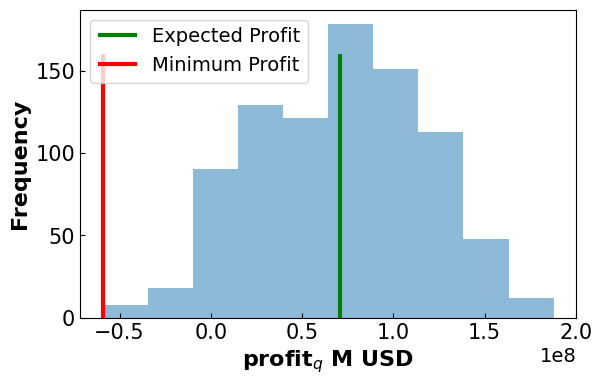

Results
-------------------------------------
Expected Profit: 70.9 M USD
Minimum Profit: -59.23 M USD
Difference: 130.13 M USD


In [ ]:
#Collect the profit distribution
profits = []
for i in m.price_time_obs:
    profits.append(pyo.value(m.profit[i]))

#Collect the minimum profit
min_prof = min(profits)

#Plot the Profit Distribution
fig, ax = plt.subplots(figsize=(6.4, 4))
plt.hist(np.array(profits), alpha = 0.5)
plt.vlines(ymin = 0,ymax= 160, x= pyo.value(m.obj), label = 'Expected Profit', color = 'green', linewidth =3)
plt.vlines(ymin = 0, ymax = 160, x=min_prof, label = ('Minimum Profit'), color = 'red', linewidth = 3)
plt.xlabel('profit$_q$ M USD', fontsize = 16, fontweight='bold')
plt.ylabel('Frequency', fontsize = 16, fontweight='bold')
plt.legend(fontsize = 14)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.tick_params(direction="in")
plt.show()

print('Results')
print('-------------------------------------')
print('Expected Profit:', np.round(pyo.value(m.obj)/1e6,2), 'M USD')
print('Minimum Profit:', np.round(min_prof/1e6,2), 'M USD')
difference = pyo.value(m.obj) - min_prof
print('Difference:', np.round(difference/1e6,2), 'M USD')

#Collect Results for Conclusion
final_EP = {}
final_min = {}
final_diff = {}

final_EP['No Risk'] = pyo.value(m.obj)/1e6
final_min['No Risk'] = min_prof/1e6
final_diff['No Risk'] = difference/1e6

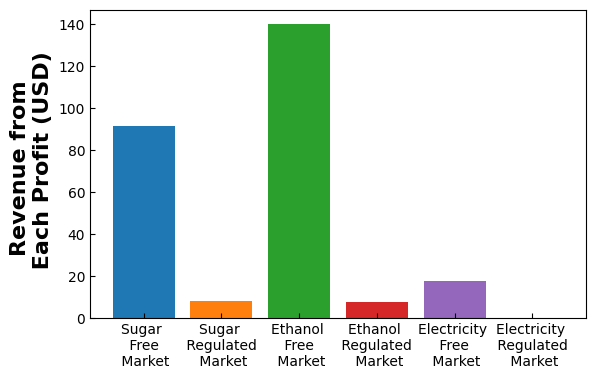

In [ ]:
fig, ax = plt.subplots(figsize=(6.4, 4))
plt.bar('Sugar \n Free \n Market',pyo.value(m.avg_sug_Fprof)/1e6)
plt.bar('Sugar \n Regulated \n Market',pyo.value(m.avg_sug_Rprof)/1e6)
plt.bar('Ethanol \n Free \n Market', pyo.value(m.avg_eth_Fprof)/1e6)
plt.bar('Ethanol \n Regulated \n Market', pyo.value(m.avg_eth_Rprof)/1e6)
plt.bar('Electricity \n Free \n Market', pyo.value(m.avg_el_prof)/1e6)
plt.bar('Electricity \n Regulated \n Market', pyo.value(m.q_el_reg)*72.5/1e6)
plt.ylabel('Product', fontsize = 16, fontweight='bold')
plt.ylabel('Revenue from \n Each Profit (USD)', fontsize = 16, fontweight='bold')
ax.xaxis.set_tick_params(labelsize=10)
ax.yaxis.set_tick_params(labelsize=10)
ax.tick_params(direction="in")
plt.show()

In [ ]:
#Calculate the Covariance Matrix

#Drop the scenario number column
price = df_hp.drop(columns = ['q'])

#Calculate Returns
Returns = price.diff()/price.shift(1)

covar = Returns.cov()
print('Covariance Matrix')
print('-------------------')
print(covar)

Covariance Matrix
-------------------
          fre       sug       eth
fre  0.094993 -0.000350 -0.000756
sug -0.000350  0.000922  0.000390
eth -0.000756  0.000390  0.001578


In [ ]:
#Reload the base Model
m = create_model()

#Define MV as the objective
def mean_value(m):
    # Assume covar is the covariance matrix dataframe
    return (
        2 * (m.q_sugar_free * covar.loc['sug', 'eth'] * m.q_eth_free) +
        2 * (m.q_sugar_free * covar.loc['sug', 'fre'] * m.q_el_free) +
        2 *(m.q_eth_free * covar.loc['eth', 'fre'] * m.q_el_free)
    )
m.obj = pyo.Objective(rule = mean_value, sense = pyo.minimize)

#Solve the Model
sol =pyo.SolverFactory('bonmin')

sol.solve(m)

print('Results')
print('--------------------------------------')
print('Expected Profit', np.round(pyo.value(m.EP),2), 'USD')
print(f"Sugar to Regulated Market: {pyo.value(m.q_sugar_reg)}")
print(f"Sugar to Free Market: {pyo.value(m.q_sugar_free)}")
print(f"Ethanol to Regulated Market: {pyo.value(m.q_eth_reg)}")
print(f"Ethanol to Free Market: {pyo.value(m.q_eth_free)}")
print(f"Electricity to Free Market: {pyo.value(m.q_el_free)}")
print(f"Electricity to Regulated Market: {pyo.value(m.q_el_reg)}")


Results
--------------------------------------
Expected Profit 46938216.89 USD
Sugar to Regulated Market: 90000.0009
Sugar to Free Market: 18074.160180748422
Ethanol to Regulated Market: 19999.9998
Ethanol to Free Market: 292292.4480869271
Electricity to Free Market: 222600.00222601
Electricity to Regulated Market: 0.0


In [ ]:
#Reload the base Model
m = create_model()

#Define MV as the objective
def mean_value(m):
    # Assume covar is the covariance matrix dataframe
    return (
        2 * (m.q_sugar_free * covar.loc['sug', 'eth'] * m.q_eth_free) +
        2 * (m.q_sugar_free * covar.loc['sug', 'fre'] * m.q_el_free) +
        2 *(m.q_eth_free * covar.loc['eth', 'fre'] * m.q_el_free)
    )
m.obj = pyo.Objective(rule = mean_value, sense = pyo.minimize)

#Solve the Model
sol =pyo.SolverFactory('bonmin')

sol.solve(m)

print('Results')
print('--------------------------------------')
print('Expected Profit', np.round(pyo.value(m.EP),2), 'USD')
print(f"Sugar to Regulated Market: {pyo.value(m.q_sugar_reg)}")
print(f"Sugar to Free Market: {pyo.value(m.q_sugar_free)}")
print(f"Ethanol to Regulated Market: {pyo.value(m.q_eth_reg)}")
print(f"Ethanol to Free Market: {pyo.value(m.q_eth_free)}")
print(f"Electricity to Free Market: {pyo.value(m.q_el_free)}")
print(f"Electricity to Regulated Market: {pyo.value(m.q_el_reg)}")


Results
--------------------------------------
Expected Profit 46938216.89 USD
Sugar to Regulated Market: 90000.0009
Sugar to Free Market: 18074.160180748422
Ethanol to Regulated Market: 19999.9998
Ethanol to Free Market: 292292.4480869271
Electricity to Free Market: 222600.00222601
Electricity to Regulated Market: 0.0


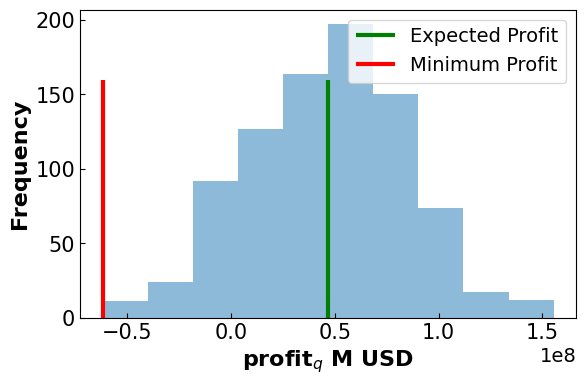

Results
-------------------------------------
Expected Profit: 46.94 M USD
Minimum Profit: -61.78 M USD
Difference: 108.72 M USD


In [ ]:
#Collect the profit distribution
profits = []
for i in m.price_time_obs:
    profits.append(pyo.value(m.profit[i]))

#Collect the minimum profit
min_prof = min(profits)

#Plot the Profit Distribution
fig, ax = plt.subplots(figsize=(6.4, 4))
plt.hist(np.array(profits), alpha = 0.5)
plt.vlines(ymin = 0,ymax= 160, x= pyo.value(m.EP), label = 'Expected Profit', color = 'green', linewidth =3)
plt.vlines(ymin = 0, ymax = 160, x=min_prof, label = ('Minimum Profit'), color = 'red', linewidth = 3)
plt.xlabel('profit$_q$ M USD', fontsize = 16, fontweight='bold')
plt.ylabel('Frequency', fontsize = 16, fontweight='bold')
plt.legend(fontsize = 14)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.tick_params(direction="in")
plt.show()

print('Results')
print('-------------------------------------')
print('Expected Profit:', np.round(pyo.value(m.EP)/1e6,2), 'M USD')
print('Minimum Profit:', np.round(min_prof/1e6,2), 'M USD')
difference = pyo.value(m.EP) - min_prof
print('Difference:', np.round(difference/1e6,2), 'M USD')

final_EP['MV'] = pyo.value(m.obj)/1e6
final_min['MV'] = min_prof/1e6
final_diff['MV'] = difference/1e6

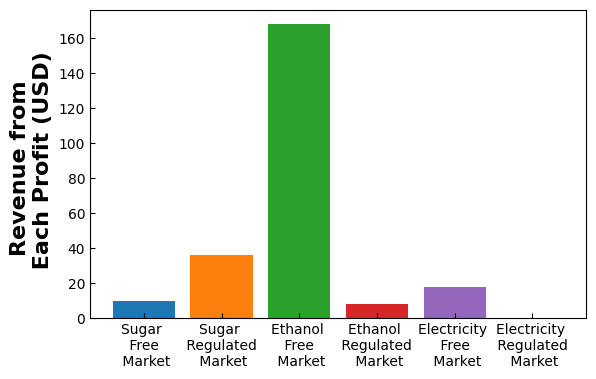

In [ ]:
fig, ax = plt.subplots(figsize=(6.4, 4))
plt.bar('Sugar \n Free \n Market',pyo.value(m.avg_sug_Fprof)/1e6)
plt.bar('Sugar \n Regulated \n Market',pyo.value(m.avg_sug_Rprof)/1e6)
plt.bar('Ethanol \n Free \n Market', pyo.value(m.avg_eth_Fprof)/1e6)
plt.bar('Ethanol \n Regulated \n Market', pyo.value(m.avg_eth_Rprof)/1e6)
plt.bar('Electricity \n Free \n Market', pyo.value(m.avg_el_prof)/1e6)
plt.bar('Electricity \n Regulated \n Market', pyo.value(m.q_el_reg)*72.5/1e6)
plt.ylabel('Product', fontsize = 16, fontweight='bold')
plt.ylabel('Revenue from \n Each Profit (USD)', fontsize = 16, fontweight='bold')
ax.xaxis.set_tick_params(labelsize=10)
ax.yaxis.set_tick_params(labelsize=10)
ax.tick_params(direction="in")
plt.show()

In [ ]:
#Reload the base Model
m = create_model()

#Create set of return indicies
J = np.arange(1,m.N)

#Create new variables
m.y_aux = pyo.Var(J, within = pyo.NonNegativeReals)
m.z_aux = pyo.Var(J, within = pyo.NonNegativeReals)

#Constrain y - z to be the abs portion
def aux_con(m, j):
    return m.y_aux[j] - m.z_aux[j] == (
        m.q_sugar_free * (Returns.loc[j, 'sug'] - (1/m.N) * Returns['sug'].mean()) +
        m.q_eth_free * (Returns.loc[j, 'eth'] - (1/m.N) * Returns['eth'].mean()) +
        m.q_el_free * (Returns.loc[j, 'fre'] - (1/m.N) * Returns['fre'].mean())
    )
m.aux_constraint = pyo.Constraint(J, rule=aux_con)

#Define MAD as the objective
def mad(m):
    return (1/m.N) * sum(m.y_aux[j] + m.z_aux[j] for j in J)
m.obj = pyo.Objective(rule=mad, sense=pyo.minimize)

#Solve the Model
sol =pyo.SolverFactory('bonmin')

results = sol.solve(m)

print('Results')
print('------------------------------')
print('Expected Profit', np.round(pyo.value(m.EP),2), 'USD')
print(f"Sugar to Regulated Market: {pyo.value(m.q_sugar_reg)}")
print(f"Sugar to Free Market: {pyo.value(m.q_sugar_free)}")
print(f"Ethanol to Regulated Market: {pyo.value(m.q_eth_reg)}")
print(f"Ethanol to Free Market: {pyo.value(m.q_eth_free)}")
print(f"Electricity to Free Market: {pyo.value(m.q_el_free)}")
print(f"Electricity to Regulated Market: {pyo.value(m.q_el_reg)}")

Results
------------------------------
Expected Profit 7062325.29 USD
Sugar to Regulated Market: 20319.69533262694
Sugar to Free Market: 999.9999900006177
Ethanol to Regulated Market: 20205.60275053846
Ethanol to Free Market: 999.9999900004543
Electricity to Free Market: 7.378656985065415
Electricity to Regulated Market: 107036.64387638078


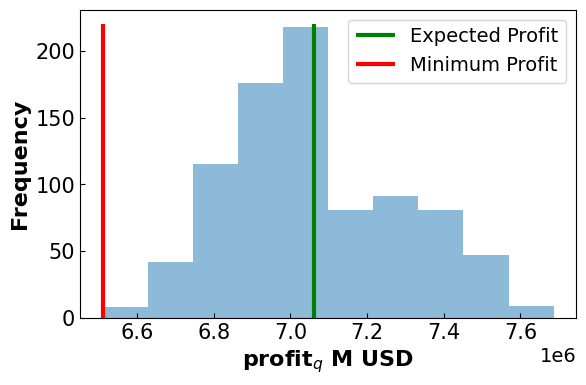

Results
-------------------------------------
Expected Profit: 7.06 M USD
Minimum Profit: 6.51 M USD
Difference: 0.55 M USD


In [ ]:
#Collect the profit distribution
profits = []
for i in m.price_time_obs:
    profits.append(pyo.value(m.profit[i]))

#Collect the minimum profit
min_prof = min(profits)

#Plot the Profit Distribution
fig, ax = plt.subplots(figsize=(6.4, 4))
plt.hist(np.array(profits), alpha = 0.5)
plt.vlines(ymin = 0,ymax= 220, x= pyo.value(m.EP), label = 'Expected Profit', color = 'green')
plt.vlines(ymin = 0, ymax = 220, x=min_prof, label = ('Minimum Profit'), color = 'red')
plt.xlabel('profit$_q$ M USD', fontsize = 16, fontweight='bold')
plt.ylabel('Frequency', fontsize = 16, fontweight='bold')
plt.legend(fontsize = 14)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.tick_params(direction="in")
plt.show()

print('Results')
print('-------------------------------------')
print('Expected Profit:', np.round(pyo.value(m.EP)/1e6,2), 'M USD')
print('Minimum Profit:', np.round(min_prof/1e6,2), 'M USD')
difference = pyo.value(m.EP) - min_prof
print('Difference:', np.round(difference/1e6,2), 'M USD')

#Collect results for conclusion
final_EP['MAD'] = pyo.value(m.EP)/1e6
final_min['MAD'] = min_prof/1e6
final_diff['MAD'] = difference/1e6

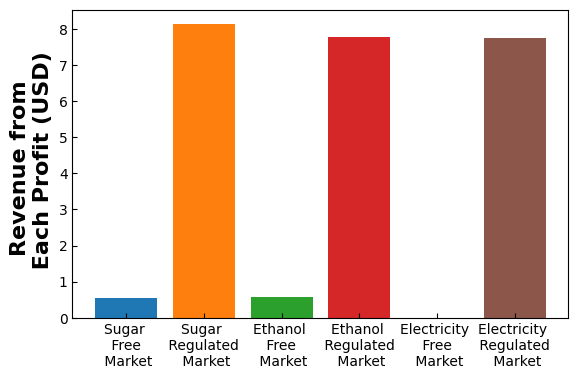

In [ ]:
fig, ax = plt.subplots(figsize=(6.4, 4))
plt.bar('Sugar \n Free \n Market',pyo.value(m.avg_sug_Fprof)/1e6)
plt.bar('Sugar \n Regulated \n Market',pyo.value(m.avg_sug_Rprof)/1e6)
plt.bar('Ethanol \n Free \n Market', pyo.value(m.avg_eth_Fprof)/1e6)
plt.bar('Ethanol \n Regulated \n Market', pyo.value(m.avg_eth_Rprof)/1e6)
plt.bar('Electricity \n Free \n Market', pyo.value(m.avg_el_prof)/1e6)
plt.bar('Electricity \n Regulated \n Market', pyo.value(m.q_el_reg)*72.5/1e6)
plt.ylabel('Product', fontsize = 16, fontweight='bold')
plt.ylabel('Revenue from \n Each Profit (USD)', fontsize = 16, fontweight='bold')
ax.xaxis.set_tick_params(labelsize=10)
ax.yaxis.set_tick_params(labelsize=10)
ax.tick_params(direction="in")
plt.show()

In [ ]:
# Reload the base Model
m = create_model()

# Add parameters
beta = 0.9  # confidence interval

# Add variables for CVaR
m.shortfall = pyo.Var(m.price_time_obs, within=pyo.NonNegativeReals, initialize=0)
m.alpha = pyo.Var(within=pyo.Reals, initialize=0)
m.CVaR = pyo.Var(within=pyo.Reals, initialize=0)

# Add CVaR Constraints
def CVaR1(m):
    return m.CVaR == m.alpha - (1 / (m.N * (1 - beta))) * sum(m.shortfall[q] for q in m.price_time_obs)
m.cvar1eq = pyo.Constraint(rule=CVaR1)

def CVaR2(m, q):
    return m.shortfall[q] >= 0
m.cvar2eq = pyo.Constraint(m.price_time_obs, rule=CVaR2)

def CVaR4(m, q):
    return m.profit[q] + m.shortfall[q] - m.alpha >= 0
m.cvar4eq = pyo.Constraint(m.price_time_obs, rule=CVaR4)

# Objective: Maximize CVaR
def obj_rule(m):
    return m.CVaR
m.obj = pyo.Objective(rule=obj_rule, sense=pyo.maximize)

# Solve the Model
sol = pyo.SolverFactory('bonmin')
results = sol.solve(m)

# Display Results
print('Results')
print('------------------------------')
print('Expected Profit:', np.round(pyo.value(m.EP), 2), 'USD')
print(f"Sugar to Regulated Market: {pyo.value(m.q_sugar_reg)}")
print(f"Sugar to Free Market: {pyo.value(m.q_sugar_free)}")
print(f"Ethanol to Regulated Market: {pyo.value(m.q_eth_reg)}")
print(f"Ethanol to Free Market: {pyo.value(m.q_eth_free)}")
print(f"Electricity to Free Market: {pyo.value(m.q_el_free)}")
print(f"Electricity to Regulated Market: {pyo.value(m.q_el_reg)}")

Results
------------------------------
Expected Profit: 29037733.16 USD
Sugar to Regulated Market: 90000.0009
Sugar to Free Market: 30543.781939740602
Ethanol to Regulated Market: 19999.9998
Ethanol to Free Market: 27210.972749183184
Electricity to Free Market: 0.0
Electricity to Regulated Market: 222600.00222601


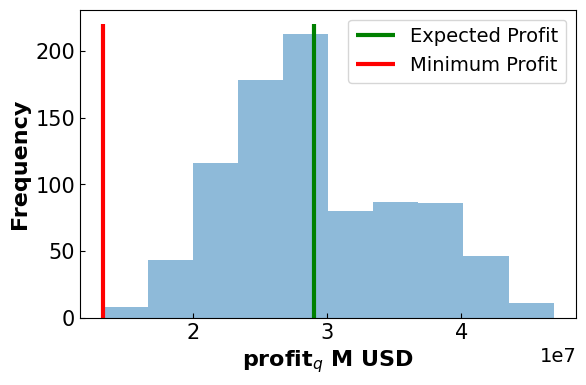

Results
-------------------------------------
Expected Profit: 29.04 M USD
Minimum Profit: 13.23 M USD
Difference: 15.81 M USD


In [ ]:
#Collect the profit distribution
profits = []
for i in m.price_time_obs:
    profits.append(pyo.value(m.profit[i]))

#Collect the minimum profit
min_prof = min(profits)

#Plot the Profit Distribution
fig, ax = plt.subplots(figsize=(6.4, 4))
plt.hist(np.array(profits), alpha = 0.5)
plt.vlines(ymin = 0,ymax= 220, x= pyo.value(m.EP), label = 'Expected Profit', color = 'green')
plt.vlines(ymin = 0, ymax = 220, x=min_prof, label = ('Minimum Profit'), color = 'red')
plt.xlabel('profit$_q$ M USD', fontsize = 16, fontweight='bold')
plt.ylabel('Frequency', fontsize = 16, fontweight='bold')
plt.legend(fontsize = 14)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.tick_params(direction="in")
plt.show()

print('Results')
print('-------------------------------------')
print('Expected Profit:', np.round(pyo.value(m.EP)/1e6,2), 'M USD')
print('Minimum Profit:', np.round(min_prof/1e6,2), 'M USD')
difference = pyo.value(m.EP) - min_prof
print('Difference:', np.round(difference/1e6,2), 'M USD')

#Collect results for conclusion
final_EP['CVaR'] = pyo.value(m.EP)/1e6
final_min['CVaR'] = min_prof/1e6
final_diff['CVaR'] = difference/1e6

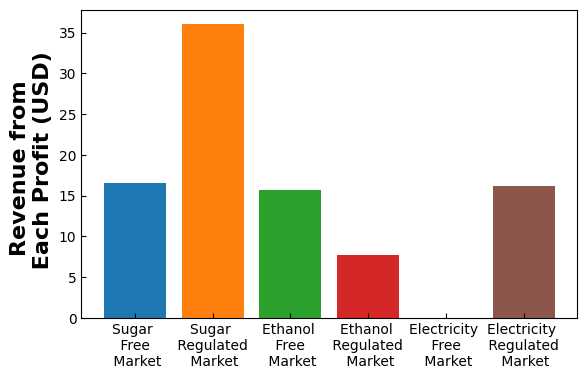

In [ ]:
fig, ax = plt.subplots(figsize=(6.4, 4))
plt.bar('Sugar \n Free \n Market',pyo.value(m.avg_sug_Fprof)/1e6)
plt.bar('Sugar \n Regulated \n Market',pyo.value(m.avg_sug_Rprof)/1e6)
plt.bar('Ethanol \n Free \n Market', pyo.value(m.avg_eth_Fprof)/1e6)
plt.bar('Ethanol \n Regulated \n Market', pyo.value(m.avg_eth_Rprof)/1e6)
plt.bar('Electricity \n Free \n Market', pyo.value(m.avg_el_prof)/1e6)
plt.bar('Electricity \n Regulated \n Market', pyo.value(m.q_el_reg)*72.5/1e6)
plt.ylabel('Product', fontsize = 16, fontweight='bold')
plt.ylabel('Revenue from \n Each Profit (USD)', fontsize = 16, fontweight='bold')
ax.xaxis.set_tick_params(labelsize=10)
ax.yaxis.set_tick_params(labelsize=10)
ax.tick_params(direction="in")
plt.show()